In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys
import time
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize


def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata


import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False, verbose=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verbose, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(8,4))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    

Using TensorFlow backend.


### Sólo un canal (izq-der)

In [2]:
df_sets = pd.read_csv("../../KOI_Data/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values   #validation
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01      Train
1  K01009.01      Train
2  K07621.01       Test
3  K06252.01       Test
4  K00958.01  Unlabeled

In [3]:
df_meta = pd.read_csv("../../KOI_Data/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]
df_meta_train.head()

KOI Name NExScI Disposition   Kepler Name      Period  \
0   K00889.01          CONFIRMED   Kepler-75 b    8.884923   
1   K01009.01     FALSE POSITIVE           NaN    5.092465   
7   K07622.01     FALSE POSITIVE           NaN   36.267167   
9   K00998.01     FALSE POSITIVE           NaN  161.788327   
10  K00992.01          CONFIRMED  Kepler-745 b    9.931463   

    Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
0              169.991686               2455002.992             0.069   
1              357.535940               2455190.536             0.161   
7              155.081300               2454988.081             0.214   
9              214.039000               2455047.039             0.267   
10             136.491280               2454969.491             0.037   

    Duration  Transit Depth    r/R  ...    Teff  log(g)  Metallicity  \
0    2.07004        16053.4  0.114  ...  5332.0   4.500        -0.08   
1    3.65900          254.0  0.014  ...  5037.0   4.547        -0.20   
7    2.06500          627.1  0.022  ...  4264.0   4.637        -0.20   
9    5.31000        87750.0  0.273  ...  6018.0   4.327         0.18   
10   5.67800          398.6  0.018  ...  5782.0   4.280         0.16   

    Stellar Radius  Stellar Mass  Max single event sigma  \
0            0.843         0.821                  61.291   
1            0.751         0.727                   3.648   
7            0.620         0.607                   3.016   
9            1.212         1.142                 341.666   
10           1.220         1.035                   4.530   

    Max Multievent sigma  Transit Model SNR  KOI count  Transit Number  
0                474.021              388.2          1             153  
1                 15.175               17.1          1             225  
7                  7.472               10.0          1              39  
9                806.993              704.5          1               9  
10                22.901               26.2          2             137  

[5 rows x 31 columns]

In [4]:
df_meta_train.shape

(4339, 31)

In [5]:
df_meta_test.shape

(1918, 31)

In [6]:
df_meta_unb.shape

(1797, 31)

In [7]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [8]:
df_meta_train.shape

(4339, 31)

## Modelo 1

### No invertido

#### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.680699 
 - val_f1: 0.692859 
 - val_f1: 0.639788 
 - val_f1: 0.680718 
 - val_f1: 0.631336 
 - val_f1: 0.660336 
 - val_f1: 0.702791 
 - val_f1: 0.621734 
 - val_f1: 0.643579 
 - val_f1: 0.686310 
 - val_f1: 0.642420 
 - val_f1: 0.643840 
 - val_f1: 0.665115 
 - val_f1: 0.688038 
 - val_f1: 0.614684 
 - val_f1: 0.551284 
 - val_f1: 0.664601 
 - val_f1: 0.640955 
 - val_f1: 0.629182 
 - val_f1: 0.627113 
 - val_f1: 0.663956 
 - val_f1: 0.571579 
 - val_f1: 0.667949 
 - val_f1: 0.647581 
 - val_f1: 0.666816 
 - val_f1: 0.632459 
 - val_f1: 0.630958 
 - val_f1: 0.512973 
 - val_f1: 0.633065 
 - val_f1: 0.630642 


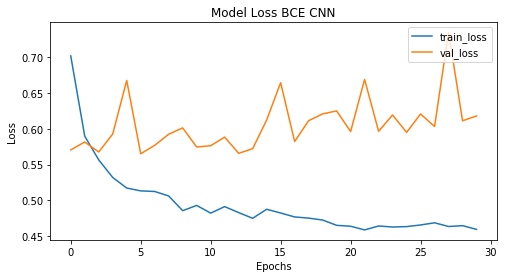

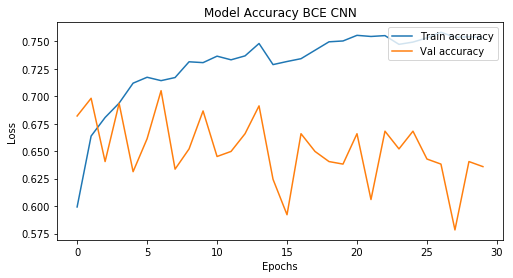

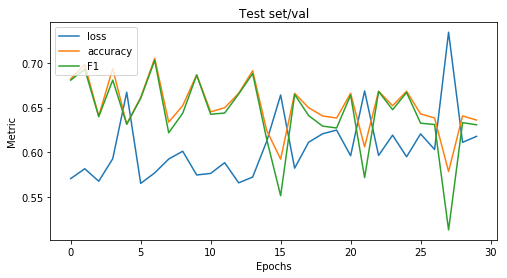

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.672617  0.696038  0.760181     0.698914       0.780405   
Confirmed       0.672617  0.696038  0.585053     0.698914       0.559946   

                Recall raw  
False Positive    0.740978  
Confirmed         0.612519

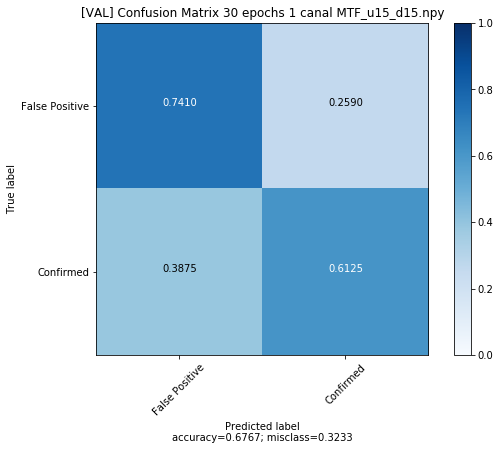

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.617382 
 - val_f1: 0.674973 
 - val_f1: 0.688460 
 - val_f1: 0.646638 
 - val_f1: 0.668095 
 - val_f1: 0.694624 
 - val_f1: 0.641255 
 - val_f1: 0.658921 
 - val_f1: 0.552147 
 - val_f1: 0.665385 
 - val_f1: 0.658805 
 - val_f1: 0.680938 
 - val_f1: 0.606891 
 - val_f1: 0.587350 
 - val_f1: 0.630462 
 - val_f1: 0.534301 
 - val_f1: 0.574132 
 - val_f1: 0.643051 
 - val_f1: 0.661202 
 - val_f1: 0.469699 
 - val_f1: 0.594115 
 - val_f1: 0.497985 
 - val_f1: 0.688859 
 - val_f1: 0.603126 
 - val_f1: 0.564416 
 - val_f1: 0.435616 
 - val_f1: 0.518500 
 - val_f1: 0.492112 
 - val_f1: 0.602701 
 - val_f1: 0.485466 


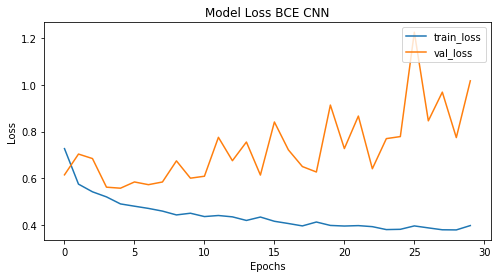

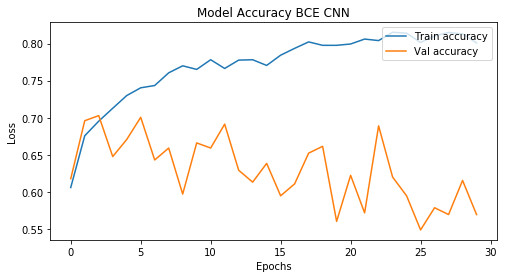

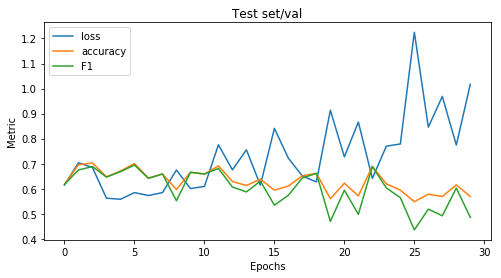

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.561907  0.676747  0.786207     0.629267       0.689655   
Confirmed       0.561907  0.676747  0.337607     0.629267       0.596226   

                Recall raw  
False Positive    0.914194  
Confirmed         0.235469

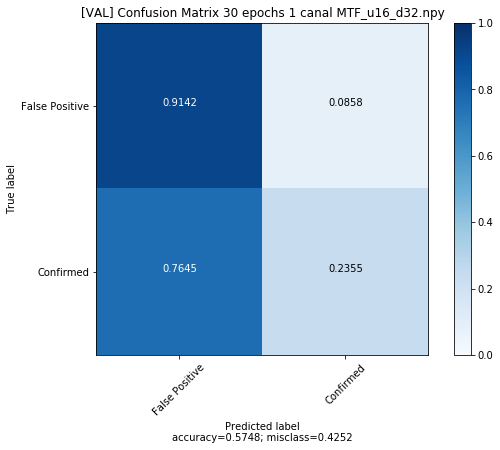

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.658996 
 - val_f1: 0.637837 
 - val_f1: 0.685746 
 - val_f1: 0.650513 
 - val_f1: 0.679303 
 - val_f1: 0.664235 
 - val_f1: 0.658725 
 - val_f1: 0.646292 
 - val_f1: 0.525209 
 - val_f1: 0.456553 
 - val_f1: 0.607413 
 - val_f1: 0.647419 
 - val_f1: 0.650722 
 - val_f1: 0.636626 
 - val_f1: 0.586395 
 - val_f1: 0.546499 
 - val_f1: 0.487366 
 - val_f1: 0.486926 
 - val_f1: 0.473314 
 - val_f1: 0.626875 
 - val_f1: 0.477738 
 - val_f1: 0.518280 
 - val_f1: 0.542336 
 - val_f1: 0.428480 
 - val_f1: 0.473081 
 - val_f1: 0.388552 
 - val_f1: 0.440845 
 - val_f1: 0.538524 
 - val_f1: 0.562507 
 - val_f1: 0.548247 


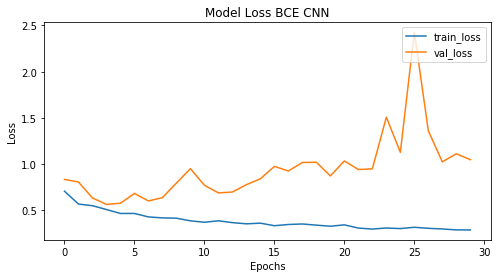

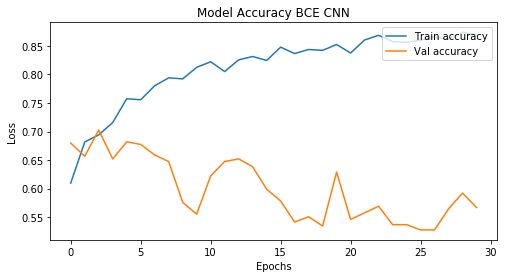

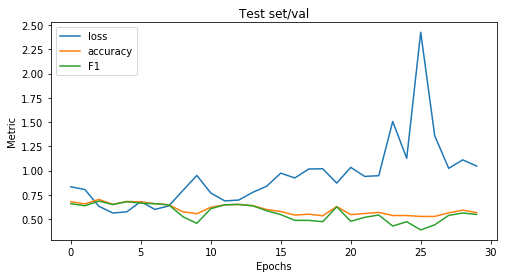

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.632076  0.668926  0.748515     0.667044       0.739437   
Confirmed       0.632076  0.668926  0.515637     0.667044       0.528125   

                Recall raw  
False Positive    0.757819  
Confirmed         0.503726

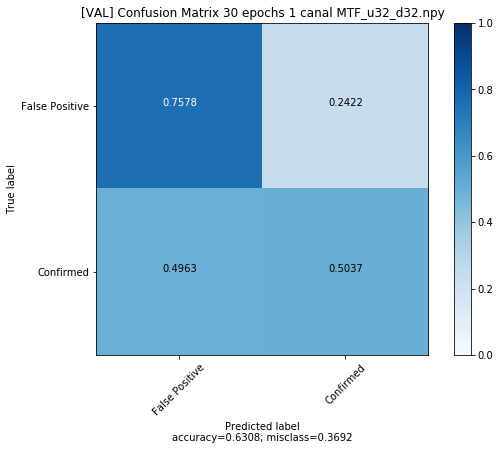

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.672366 
 - val_f1: 0.693351 
 - val_f1: 0.490936 
 - val_f1: 0.540692 
 - val_f1: 0.706933 
 - val_f1: 0.572707 
 - val_f1: 0.700773 
 - val_f1: 0.638976 
 - val_f1: 0.661245 
 - val_f1: 0.686310 
 - val_f1: 0.665812 
 - val_f1: 0.677173 
 - val_f1: 0.559790 
 - val_f1: 0.670365 
 - val_f1: 0.701775 
 - val_f1: 0.549895 
 - val_f1: 0.630642 
 - val_f1: 0.624142 
 - val_f1: 0.647343 
 - val_f1: 0.583052 
 - val_f1: 0.533171 
 - val_f1: 0.644884 
 - val_f1: 0.533171 
 - val_f1: 0.551536 
 - val_f1: 0.499150 
 - val_f1: 0.586930 
 - val_f1: 0.618195 
 - val_f1: 0.618430 
 - val_f1: 0.567824 
 - val_f1: 0.609957 


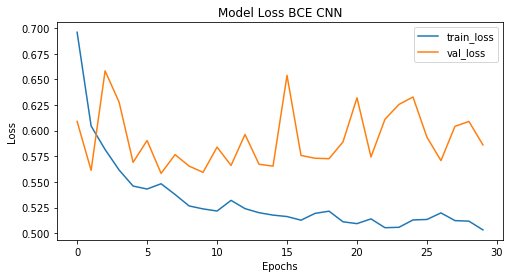

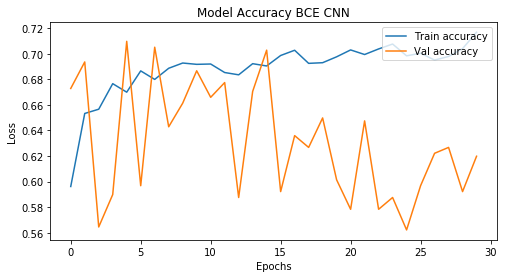

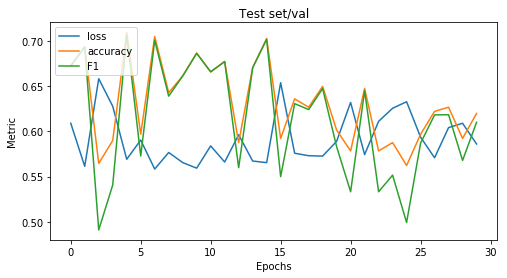

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.651845  0.678832  0.748777     0.680955       0.761826   
Confirmed       0.651845  0.678832  0.554913     0.680955       0.538569   

                Recall raw  
False Positive    0.736167  
Confirmed         0.572280

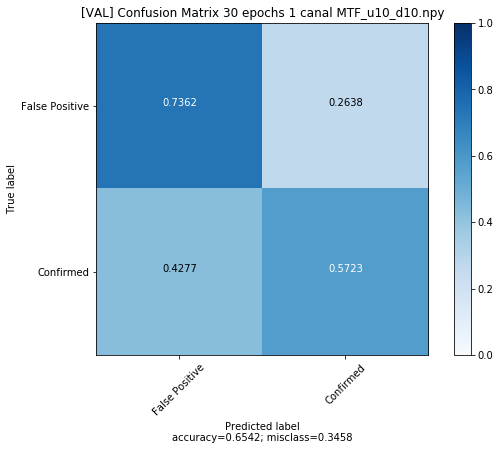

In [9]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.601413 
 - val_f1: 0.641730 
 - val_f1: 0.672917 
 - val_f1: 0.660199 
 - val_f1: 0.644684 
 - val_f1: 0.655762 
 - val_f1: 0.639404 
 - val_f1: 0.683935 
 - val_f1: 0.684585 
 - val_f1: 0.708796 
 - val_f1: 0.690787 
 - val_f1: 0.667949 
 - val_f1: 0.704472 
 - val_f1: 0.702791 
 - val_f1: 0.695853 
 - val_f1: 0.662728 
 - val_f1: 0.682021 
 - val_f1: 0.673658 
 - val_f1: 0.581404 
 - val_f1: 0.647202 
 - val_f1: 0.659073 
 - val_f1: 0.576480 
 - val_f1: 0.652719 
 - val_f1: 0.657561 
 - val_f1: 0.601817 
 - val_f1: 0.641470 
 - val_f1: 0.692397 
 - val_f1: 0.645790 
 - val_f1: 0.652341 
 - val_f1: 0.638619 


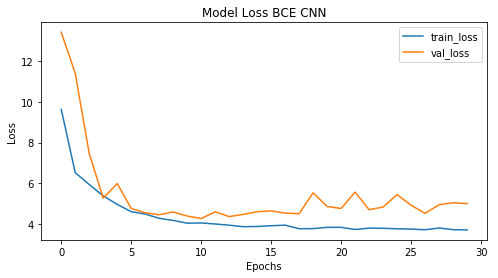

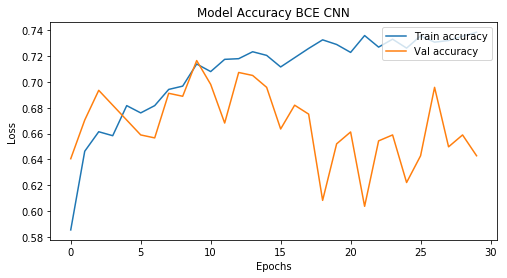

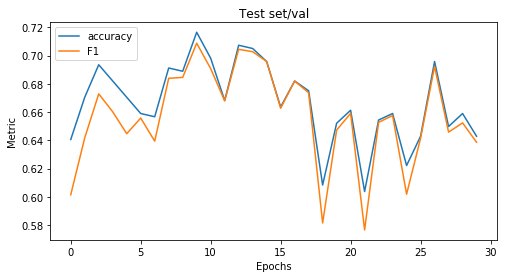

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.659146  0.679353  0.742138      0.68407       0.777680   
Confirmed       0.659146  0.679353  0.576154      0.68407       0.535897   

                Recall raw  
False Positive    0.709703  
Confirmed         0.622951

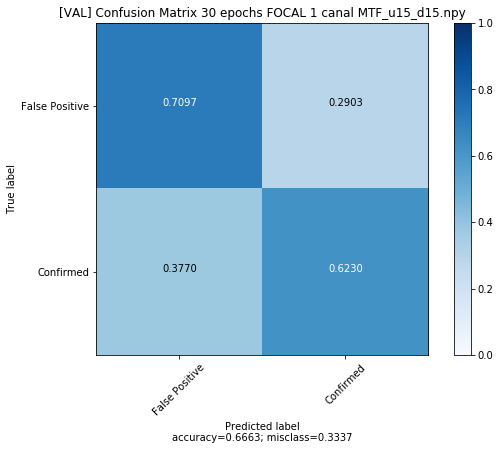

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.551871 
 - val_f1: 0.628466 
 - val_f1: 0.561084 
 - val_f1: 0.684285 
 - val_f1: 0.682948 
 - val_f1: 0.684367 
 - val_f1: 0.687131 
 - val_f1: 0.632503 
 - val_f1: 0.675588 
 - val_f1: 0.673449 
 - val_f1: 0.687372 
 - val_f1: 0.573196 
 - val_f1: 0.664400 
 - val_f1: 0.684626 
 - val_f1: 0.657758 
 - val_f1: 0.621042 
 - val_f1: 0.663530 
 - val_f1: 0.661145 
 - val_f1: 0.659771 
 - val_f1: 0.634317 
 - val_f1: 0.525461 
 - val_f1: 0.626782 
 - val_f1: 0.665854 
 - val_f1: 0.660770 
 - val_f1: 0.676243 
 - val_f1: 0.618738 
 - val_f1: 0.576590 
 - val_f1: 0.548477 
 - val_f1: 0.656636 
 - val_f1: 0.645415 


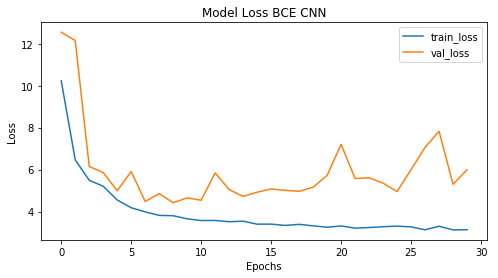

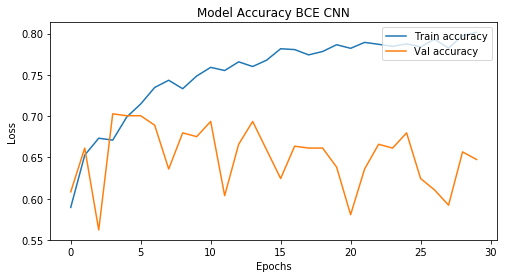

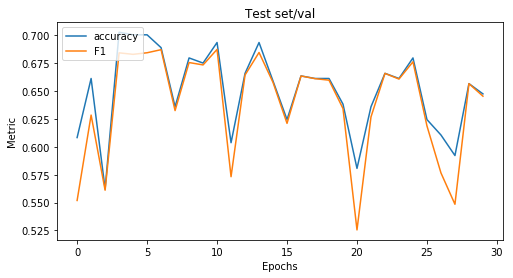

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive    0.6351  0.644943  0.695029     0.653098       0.787018   
Confirmed         0.6351  0.644943  0.575172     0.653098       0.494635   

                Recall raw  
False Positive    0.622294  
Confirmed         0.687034

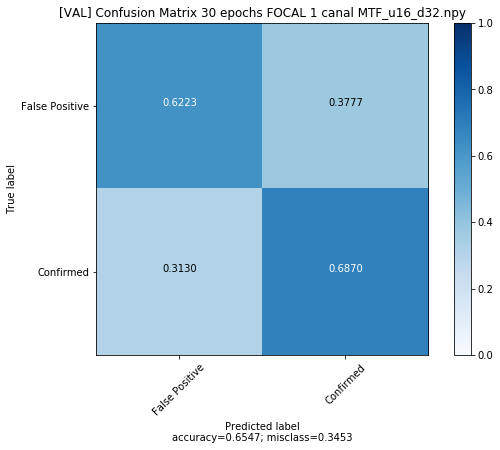

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.553530 
 - val_f1: 0.617532 
 - val_f1: 0.583853 
 - val_f1: 0.646741 
 - val_f1: 0.619147 
 - val_f1: 0.638710 
 - val_f1: 0.670048 
 - val_f1: 0.641984 
 - val_f1: 0.676717 
 - val_f1: 0.663594 
 - val_f1: 0.617032 
 - val_f1: 0.691766 
 - val_f1: 0.646806 
 - val_f1: 0.643840 
 - val_f1: 0.627508 
 - val_f1: 0.671240 
 - val_f1: 0.427032 
 - val_f1: 0.594304 
 - val_f1: 0.476654 
 - val_f1: 0.526028 
 - val_f1: 0.649584 
 - val_f1: 0.654371 
 - val_f1: 0.462245 
 - val_f1: 0.579892 
 - val_f1: 0.520503 
 - val_f1: 0.417132 
 - val_f1: 0.635875 
 - val_f1: 0.565871 
 - val_f1: 0.636133 
 - val_f1: 0.623530 


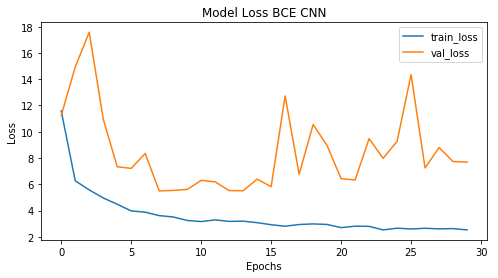

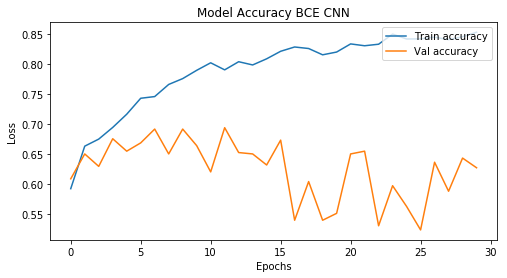

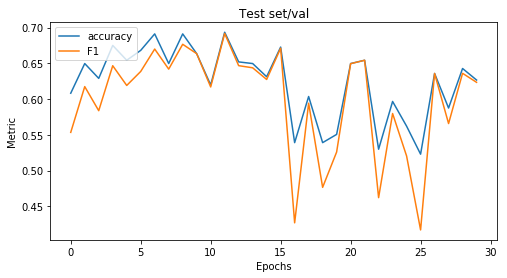

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.640584  0.664234  0.732780     0.668271       0.759243   
Confirmed       0.640584  0.664234  0.548387     0.668271       0.517881   

                Recall raw  
False Positive    0.708099  
Confirmed         0.582712

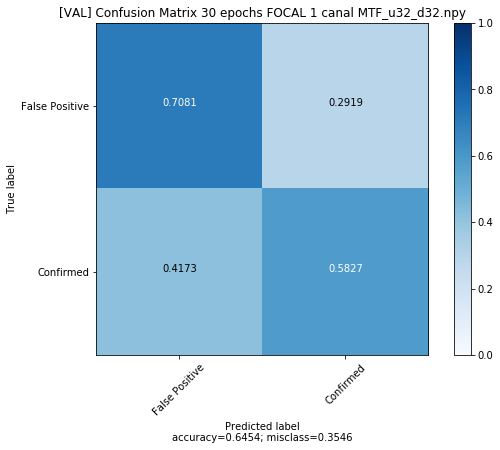

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.681967 
 - val_f1: 0.590305 
 - val_f1: 0.640522 
 - val_f1: 0.681052 
 - val_f1: 0.635718 
 - val_f1: 0.646132 
 - val_f1: 0.712137 
 - val_f1: 0.680256 
 - val_f1: 0.707949 
 - val_f1: 0.683281 
 - val_f1: 0.710442 
 - val_f1: 0.692473 
 - val_f1: 0.701476 
 - val_f1: 0.701074 
 - val_f1: 0.631762 
 - val_f1: 0.686663 
 - val_f1: 0.697548 
 - val_f1: 0.638588 
 - val_f1: 0.706926 
 - val_f1: 0.683847 
 - val_f1: 0.668139 
 - val_f1: 0.626377 
 - val_f1: 0.647855 
 - val_f1: 0.604626 
 - val_f1: 0.701863 
 - val_f1: 0.687905 
 - val_f1: 0.698027 
 - val_f1: 0.679722 
 - val_f1: 0.651539 
 - val_f1: 0.681920 


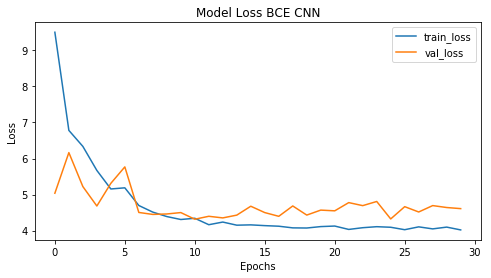

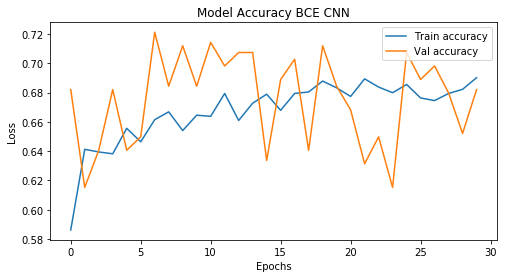

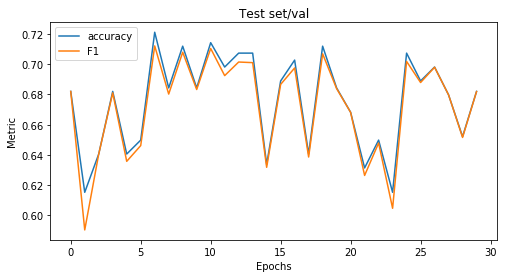

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.658626  0.664755  0.704368     0.672363       0.825431   
Confirmed       0.658626  0.664755  0.612884     0.672363       0.514141   

                Recall raw  
False Positive    0.614274  
Confirmed         0.758569

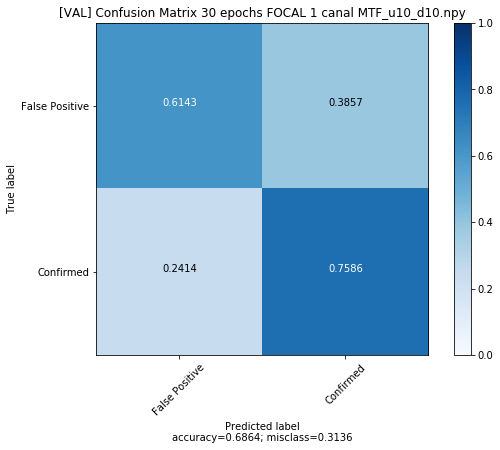

In [10]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 

### Invertido 

#### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.689223 
 - val_f1: 0.689368 
 - val_f1: 0.672804 
 - val_f1: 0.698930 
 - val_f1: 0.661245 
 - val_f1: 0.583052 
 - val_f1: 0.700088 
 - val_f1: 0.693077 
 - val_f1: 0.663480 
 - val_f1: 0.693247 
 - val_f1: 0.691080 
 - val_f1: 0.661245 
 - val_f1: 0.626257 
 - val_f1: 0.699238 
 - val_f1: 0.691238 
 - val_f1: 0.635718 
 - val_f1: 0.693077 
 - val_f1: 0.653887 
 - val_f1: 0.674034 
 - val_f1: 0.644669 
 - val_f1: 0.469922 
 - val_f1: 0.659974 
 - val_f1: 0.688925 
 - val_f1: 0.708787 
 - val_f1: 0.660495 
 - val_f1: 0.677173 
 - val_f1: 0.657349 
 - val_f1: 0.611425 
 - val_f1: 0.631437 
 - val_f1: 0.649526 


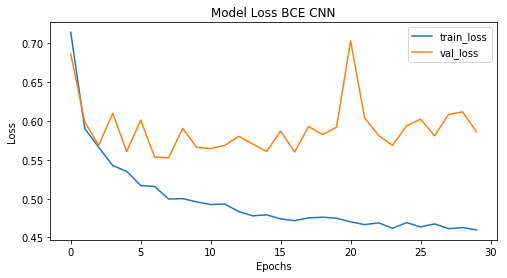

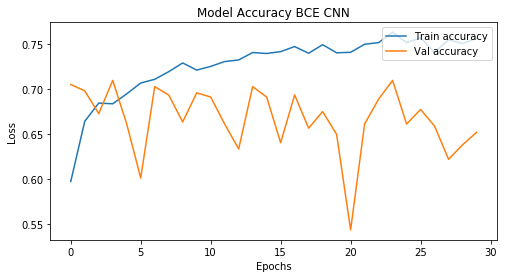

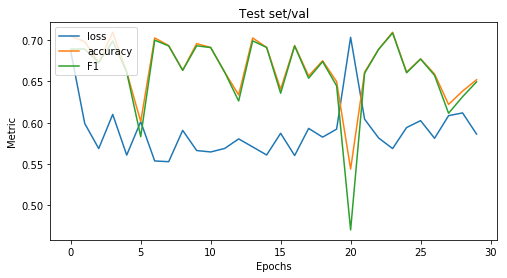

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.667201  0.690824  0.755867     0.693829       0.776650   
Confirmed       0.667201  0.690824  0.578536     0.693829       0.552989   

                Recall raw  
False Positive    0.736167  
Confirmed         0.606557

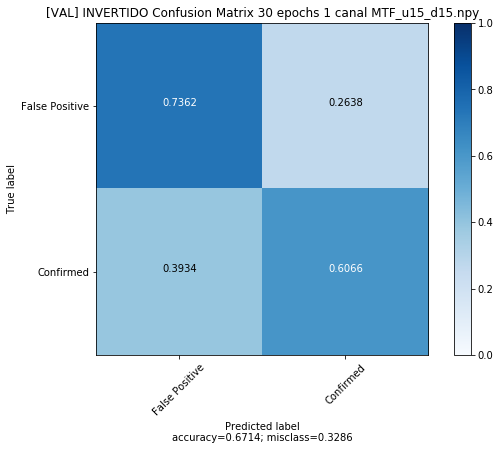

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.670048 
 - val_f1: 0.667998 
 - val_f1: 0.688546 
 - val_f1: 0.674496 
 - val_f1: 0.670544 
 - val_f1: 0.525511 
 - val_f1: 0.688652 
 - val_f1: 0.530547 
 - val_f1: 0.707621 
 - val_f1: 0.647581 
 - val_f1: 0.667751 
 - val_f1: 0.493352 
 - val_f1: 0.670008 
 - val_f1: 0.637924 
 - val_f1: 0.639934 
 - val_f1: 0.705112 
 - val_f1: 0.654113 
 - val_f1: 0.555835 
 - val_f1: 0.609507 
 - val_f1: 0.643458 
 - val_f1: 0.526796 
 - val_f1: 0.534109 
 - val_f1: 0.641668 
 - val_f1: 0.479963 
 - val_f1: 0.612863 
 - val_f1: 0.592105 
 - val_f1: 0.670197 
 - val_f1: 0.540198 
 - val_f1: 0.589865 
 - val_f1: 0.490969 


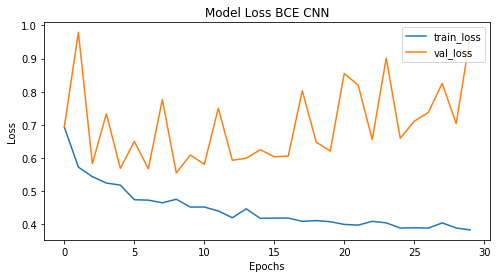

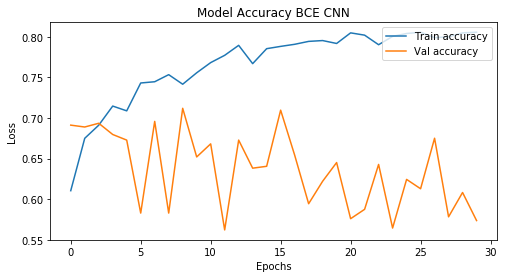

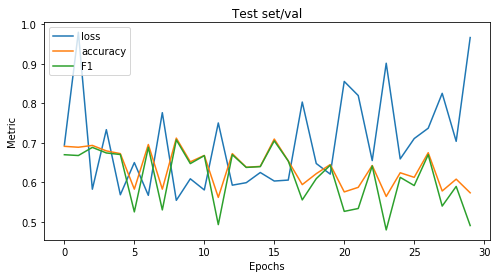

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.547385   0.67414  0.786908     0.619317       0.684460   
Confirmed       0.547385   0.67414  0.307863     0.619317       0.599138   

                Recall raw  
False Positive    0.925421  
Confirmed         0.207154

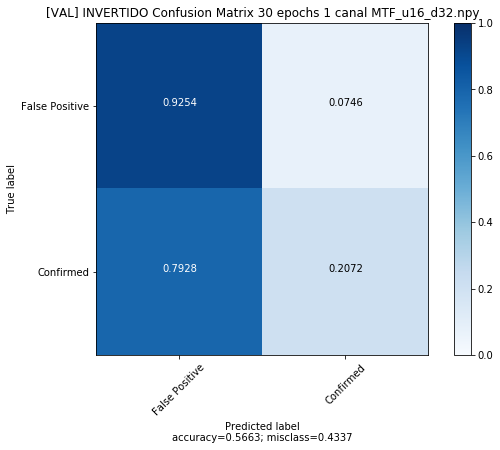

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.687618 
 - val_f1: 0.669066 
 - val_f1: 0.656636 
 - val_f1: 0.675656 
 - val_f1: 0.679456 
 - val_f1: 0.668090 
 - val_f1: 0.558569 
 - val_f1: 0.598685 
 - val_f1: 0.673658 
 - val_f1: 0.652951 
 - val_f1: 0.576600 
 - val_f1: 0.676733 
 - val_f1: 0.642420 
 - val_f1: 0.637776 
 - val_f1: 0.678821 
 - val_f1: 0.651406 
 - val_f1: 0.653487 
 - val_f1: 0.628910 
 - val_f1: 0.673425 
 - val_f1: 0.578943 
 - val_f1: 0.539456 
 - val_f1: 0.679571 
 - val_f1: 0.600096 
 - val_f1: 0.636843 
 - val_f1: 0.632043 
 - val_f1: 0.510789 
 - val_f1: 0.633065 
 - val_f1: 0.638063 
 - val_f1: 0.583344 
 - val_f1: 0.528820 


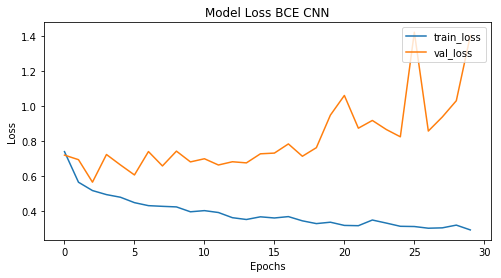

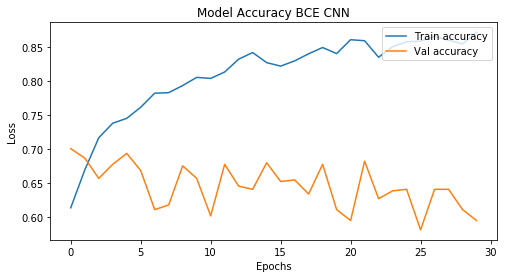

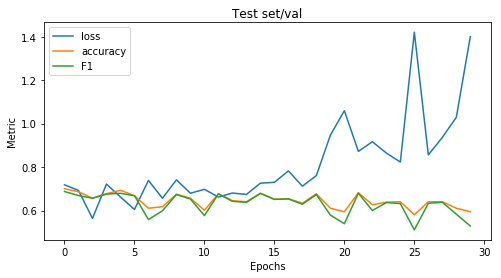

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.549374  0.673097  0.785494     0.620284       0.684964   
Confirmed       0.549374  0.673097  0.313253     0.620284       0.590909   

                Recall raw  
False Positive    0.920609  
Confirmed         0.213115

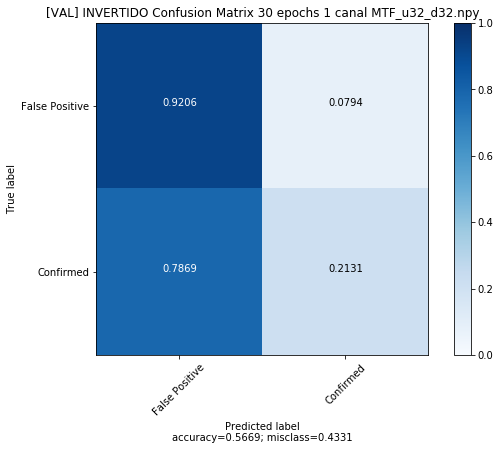

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.663179 
 - val_f1: 0.644890 
 - val_f1: 0.508055 
 - val_f1: 0.508055 
 - val_f1: 0.617440 
 - val_f1: 0.630642 
 - val_f1: 0.683591 
 - val_f1: 0.629659 
 - val_f1: 0.604839 
 - val_f1: 0.552962 
 - val_f1: 0.639258 
 - val_f1: 0.479629 
 - val_f1: 0.677413 
 - val_f1: 0.530145 
 - val_f1: 0.696751 
 - val_f1: 0.487635 
 - val_f1: 0.644291 
 - val_f1: 0.516739 
 - val_f1: 0.497451 
 - val_f1: 0.624153 
 - val_f1: 0.590458 
 - val_f1: 0.541515 
 - val_f1: 0.567451 
 - val_f1: 0.591033 
 - val_f1: 0.570722 
 - val_f1: 0.620342 
 - val_f1: 0.618294 
 - val_f1: 0.634828 
 - val_f1: 0.641470 
 - val_f1: 0.691054 


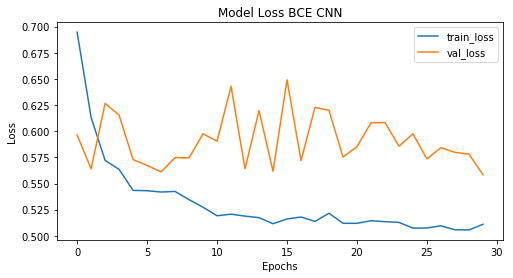

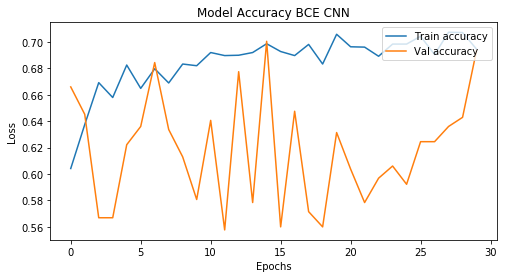

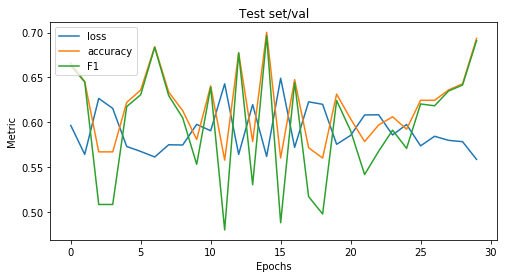

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.660763  0.664234  0.695076     0.671068       0.848555   
Confirmed       0.660763  0.664234  0.626450     0.671068       0.512821   

                Recall raw  
False Positive    0.588613  
Confirmed         0.804769

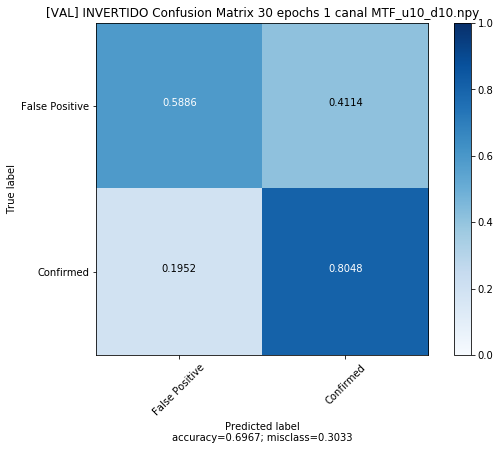

In [11]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.635676 
 - val_f1: 0.635676 
 - val_f1: 0.680874 
 - val_f1: 0.669653 
 - val_f1: 0.692038 
 - val_f1: 0.671263 
 - val_f1: 0.677116 
 - val_f1: 0.684231 
 - val_f1: 0.684812 
 - val_f1: 0.695057 
 - val_f1: 0.661245 
 - val_f1: 0.627113 
 - val_f1: 0.691080 
 - val_f1: 0.701610 
 - val_f1: 0.665854 
 - val_f1: 0.611632 
 - val_f1: 0.691238 
 - val_f1: 0.684215 
 - val_f1: 0.697577 
 - val_f1: 0.698142 
 - val_f1: 0.711838 
 - val_f1: 0.663712 
 - val_f1: 0.679340 
 - val_f1: 0.680501 
 - val_f1: 0.618952 
 - val_f1: 0.684250 
 - val_f1: 0.714391 
 - val_f1: 0.675141 
 - val_f1: 0.689105 
 - val_f1: 0.693534 


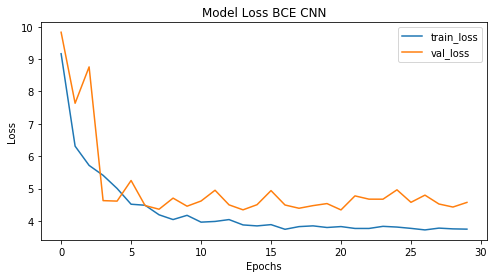

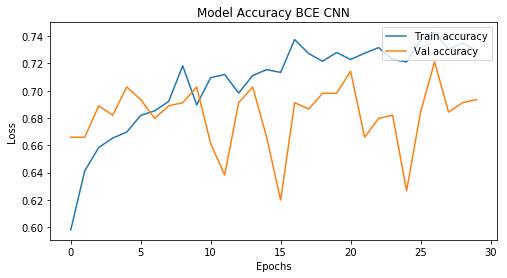

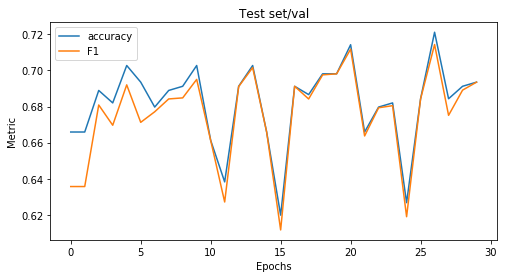

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.666418  0.678832  0.730769     0.685744       0.803074   
Confirmed       0.666418  0.678832  0.602067     0.685744       0.531357   

                Recall raw  
False Positive    0.670409  
Confirmed         0.694486

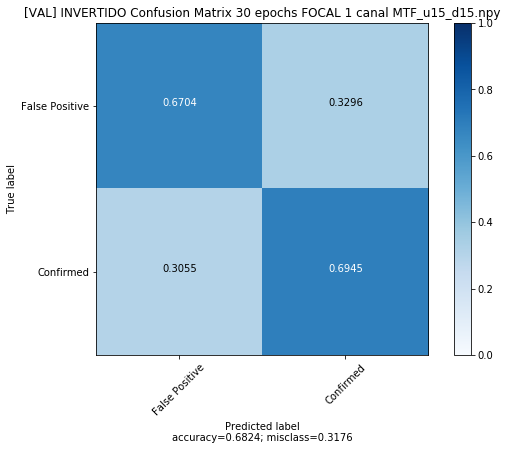

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.670048 
 - val_f1: 0.631545 
 - val_f1: 0.670862 
 - val_f1: 0.697647 
 - val_f1: 0.708959 
 - val_f1: 0.695945 
 - val_f1: 0.694259 
 - val_f1: 0.711819 
 - val_f1: 0.697487 
 - val_f1: 0.709240 
 - val_f1: 0.627987 
 - val_f1: 0.697863 
 - val_f1: 0.625755 
 - val_f1: 0.676644 
 - val_f1: 0.557793 
 - val_f1: 0.582393 
 - val_f1: 0.585398 
 - val_f1: 0.518492 
 - val_f1: 0.656593 
 - val_f1: 0.656593 
 - val_f1: 0.599826 
 - val_f1: 0.599097 
 - val_f1: 0.706654 
 - val_f1: 0.656534 
 - val_f1: 0.552126 
 - val_f1: 0.572394 
 - val_f1: 0.609507 
 - val_f1: 0.616319 
 - val_f1: 0.521437 
 - val_f1: 0.683281 


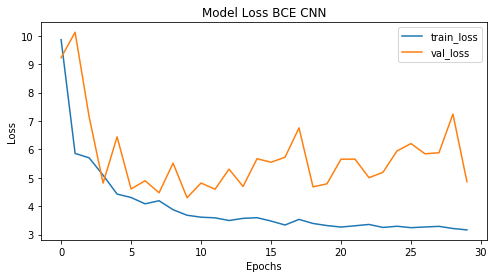

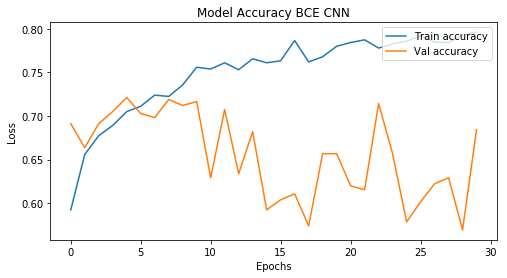

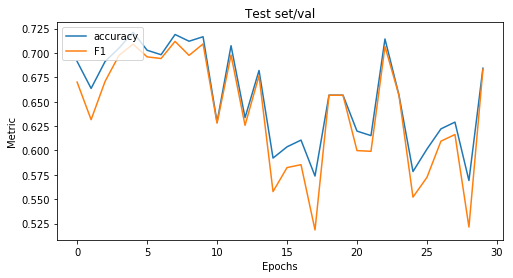

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.652361  0.656934  0.692236     0.664336       0.830527   
Confirmed       0.652361  0.656934  0.612485     0.664336       0.506329   

                Recall raw  
False Positive    0.593424  
Confirmed         0.774963

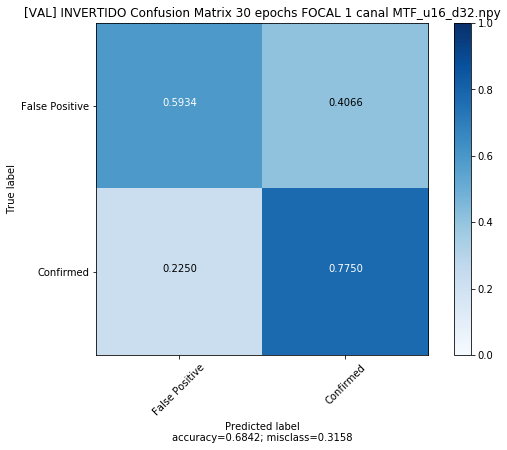

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.488310 
 - val_f1: 0.600123 
 - val_f1: 0.660494 
 - val_f1: 0.612127 
 - val_f1: 0.687806 
 - val_f1: 0.665123 
 - val_f1: 0.690703 
 - val_f1: 0.692424 
 - val_f1: 0.628360 
 - val_f1: 0.646096 
 - val_f1: 0.607885 
 - val_f1: 0.686139 
 - val_f1: 0.691231 
 - val_f1: 0.654378 
 - val_f1: 0.601320 
 - val_f1: 0.586996 
 - val_f1: 0.644884 
 - val_f1: 0.694151 
 - val_f1: 0.518295 
 - val_f1: 0.621737 
 - val_f1: 0.680699 
 - val_f1: 0.669094 
 - val_f1: 0.632217 
 - val_f1: 0.667661 
 - val_f1: 0.601518 
 - val_f1: 0.690510 
 - val_f1: 0.635318 
 - val_f1: 0.658631 
 - val_f1: 0.599826 
 - val_f1: 0.568977 


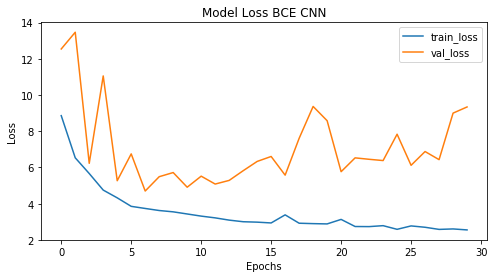

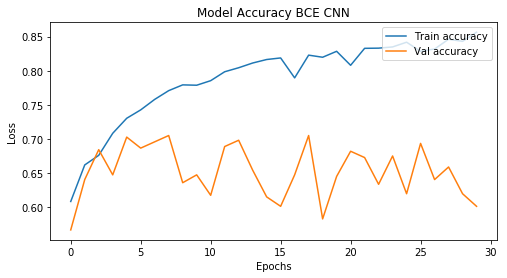

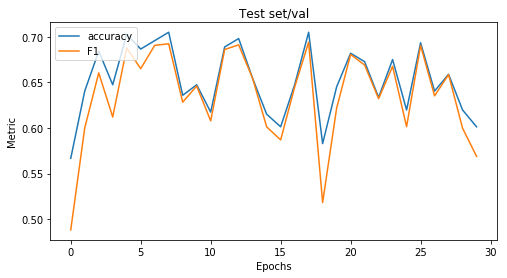

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.590342  0.666319  0.766764     0.643323       0.702739   
Confirmed       0.590342  0.666319  0.413919     0.643323       0.536817   

                Recall raw  
False Positive    0.843625  
Confirmed         0.336811

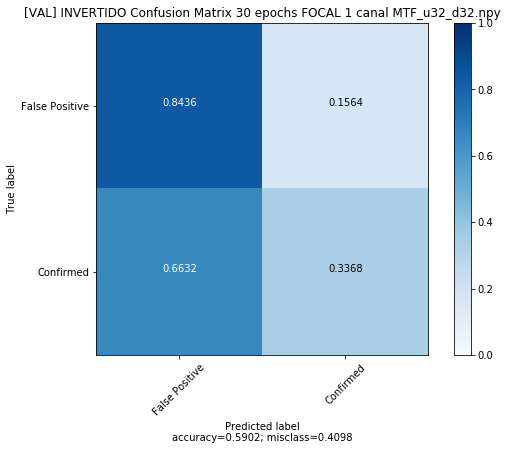

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.687263 
 - val_f1: 0.695508 
 - val_f1: 0.699338 
 - val_f1: 0.684048 
 - val_f1: 0.699706 
 - val_f1: 0.689372 
 - val_f1: 0.688652 
 - val_f1: 0.690703 
 - val_f1: 0.692859 
 - val_f1: 0.689856 
 - val_f1: 0.697913 
 - val_f1: 0.712137 
 - val_f1: 0.683673 
 - val_f1: 0.621965 
 - val_f1: 0.602751 
 - val_f1: 0.668175 
 - val_f1: 0.589587 
 - val_f1: 0.690789 
 - val_f1: 0.688546 
 - val_f1: 0.699785 
 - val_f1: 0.639627 
 - val_f1: 0.681052 
 - val_f1: 0.705449 
 - val_f1: 0.686663 
 - val_f1: 0.605361 
 - val_f1: 0.594517 
 - val_f1: 0.697913 
 - val_f1: 0.647314 
 - val_f1: 0.692074 
 - val_f1: 0.654260 


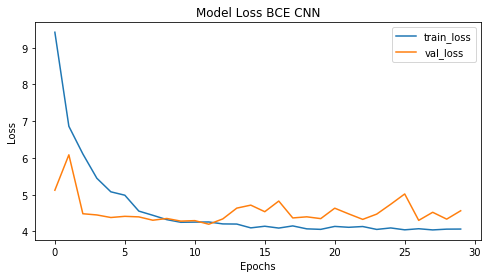

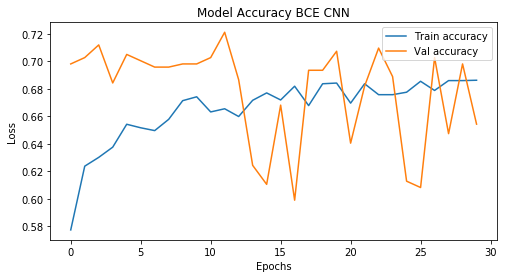

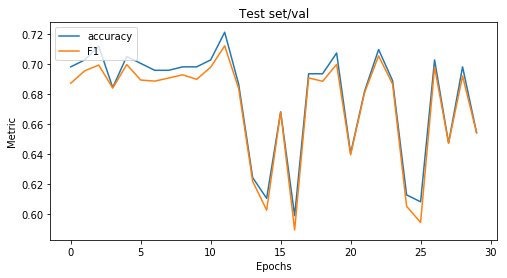

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.65394  0.667883  0.723404     0.674801       0.788826   
Confirmed        0.65394  0.667883  0.584475     0.674801       0.519722   

                Recall raw  
False Positive    0.668003  
Confirmed         0.667660

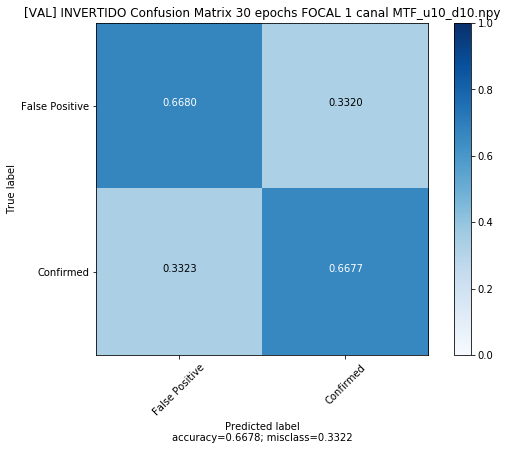

In [12]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 

## Modelo 2

### No invertido 

#### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.357139 
 - val_f1: 0.599571 
 - val_f1: 0.456374 
 - val_f1: 0.592488 
 - val_f1: 0.655539 
 - val_f1: 0.485985 
 - val_f1: 0.378956 
 - val_f1: 0.578413 
 - val_f1: 0.500329 
 - val_f1: 0.661264 
 - val_f1: 0.490298 
 - val_f1: 0.510084 
 - val_f1: 0.557657 
 - val_f1: 0.475000 
 - val_f1: 0.628433 
 - val_f1: 0.617613 
 - val_f1: 0.551534 
 - val_f1: 0.517217 
 - val_f1: 0.572783 
 - val_f1: 0.587357 
 - val_f1: 0.658695 
 - val_f1: 0.568885 
 - val_f1: 0.533835 
 - val_f1: 0.543116 
 - val_f1: 0.464113 
 - val_f1: 0.623140 
 - val_f1: 0.704007 
 - val_f1: 0.573514 
 - val_f1: 0.563288 
 - val_f1: 0.599065 


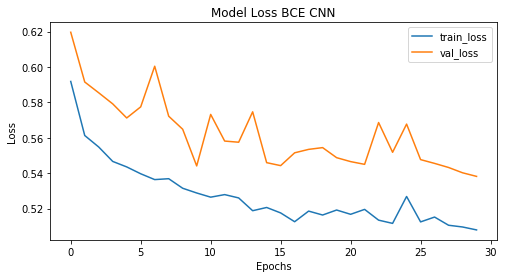

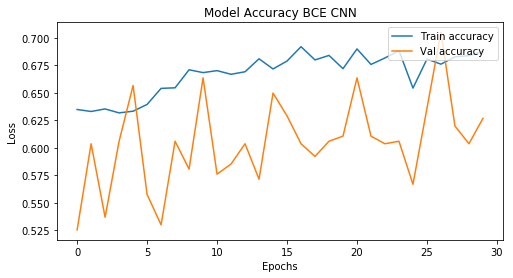

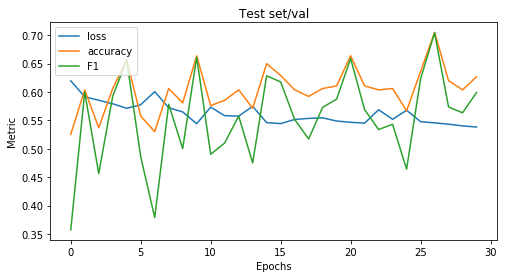

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.637919  0.702815  0.791209     0.683954       0.728254   
Confirmed       0.637919  0.702815  0.484629     0.683954       0.616092   

                Recall raw  
False Positive    0.866079  
Confirmed         0.399404

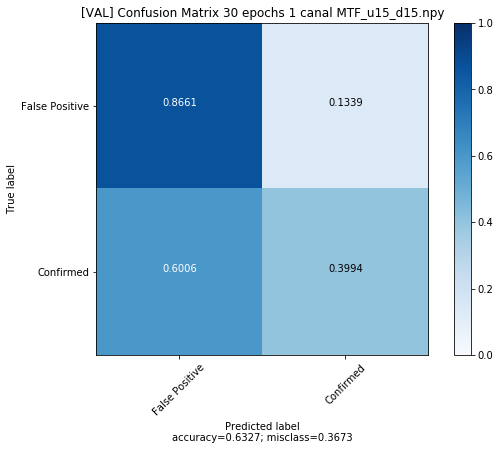

Entrenando usando representación 	Up: 16   Down: 32


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.369061 
 - val_f1: 0.456914 
 - val_f1: 0.627210 
 - val_f1: 0.641807 
 - val_f1: 0.421654 
 - val_f1: 0.532449 
 - val_f1: 0.496472 
 - val_f1: 0.486358 
 - val_f1: 0.604058 
 - val_f1: 0.510466 
 - val_f1: 0.549725 
 - val_f1: 0.509642 
 - val_f1: 0.601112 
 - val_f1: 0.532428 
 - val_f1: 0.505820 
 - val_f1: 0.561915 
 - val_f1: 0.522994 
 - val_f1: 0.509642 
 - val_f1: 0.532293 
 - val_f1: 0.518484 
 - val_f1: 0.704309 
 - val_f1: 0.594220 
 - val_f1: 0.629968 
 - val_f1: 0.517217 
 - val_f1: 0.602021 
 - val_f1: 0.566569 
 - val_f1: 0.560598 
 - val_f1: 0.630380 


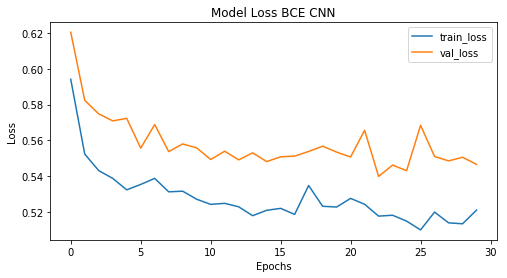

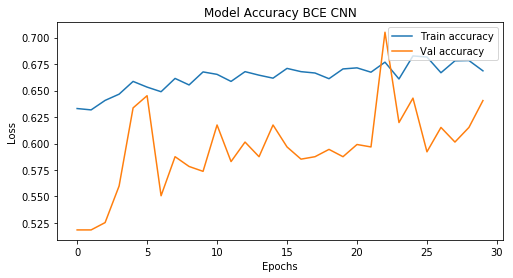

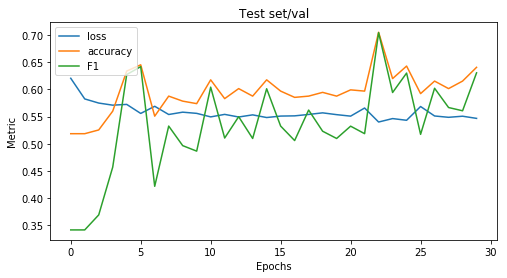

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.668728  0.708551  0.783585     0.703221       0.757485   
Confirmed       0.668728  0.708551  0.553871     0.703221       0.596220   

                Recall raw  
False Positive    0.811548  
Confirmed         0.517139

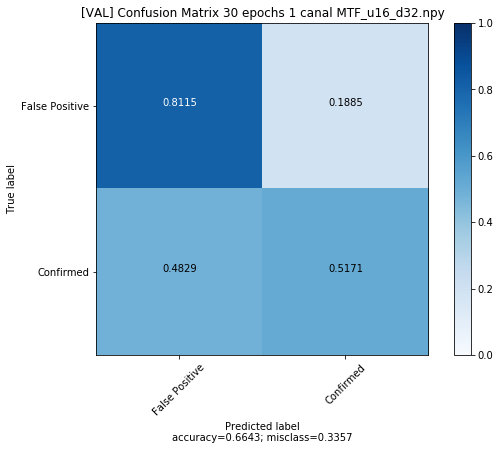

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.649166 
 - val_f1: 0.418506 
 - val_f1: 0.362291 
 - val_f1: 0.587028 
 - val_f1: 0.388698 
 - val_f1: 0.498365 
 - val_f1: 0.574654 
 - val_f1: 0.614919 
 - val_f1: 0.534287 
 - val_f1: 0.464411 
 - val_f1: 0.499197 
 - val_f1: 0.495138 
 - val_f1: 0.479079 
 - val_f1: 0.433868 
 - val_f1: 0.502345 
 - val_f1: 0.494369 
 - val_f1: 0.530684 
 - val_f1: 0.590020 
 - val_f1: 0.530676 
 - val_f1: 0.582281 
 - val_f1: 0.534174 
 - val_f1: 0.451504 
 - val_f1: 0.459911 
 - val_f1: 0.543730 
 - val_f1: 0.395987 
 - val_f1: 0.572240 
 - val_f1: 0.517871 
 - val_f1: 0.532511 
 - val_f1: 0.515121 


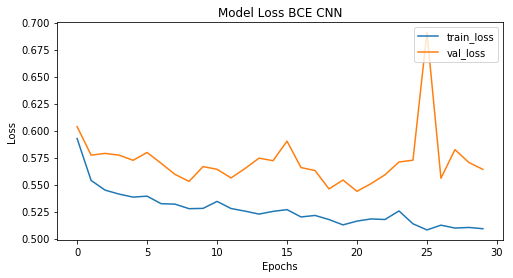

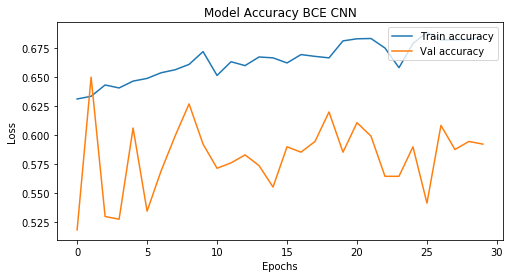

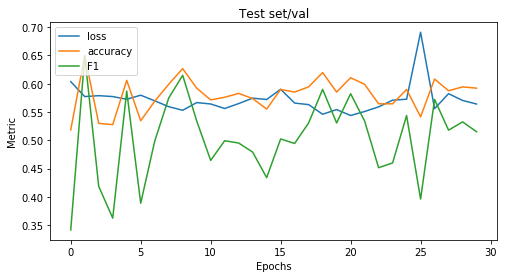

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.572657   0.70073  0.806604     0.642914       0.695526   
Confirmed       0.572657   0.70073  0.338710     0.642914       0.746193   

                Recall raw  
False Positive    0.959904  
Confirmed         0.219076

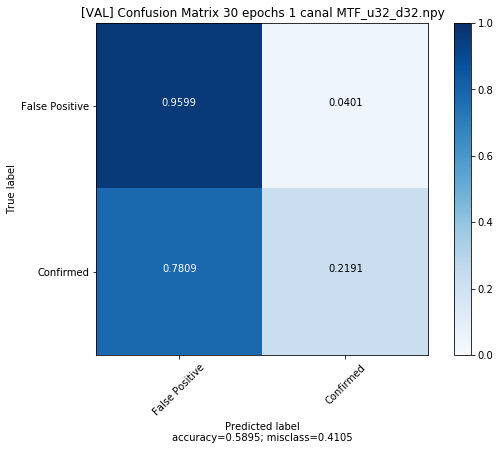

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.633183 
 - val_f1: 0.559466 
 - val_f1: 0.353494 
 - val_f1: 0.502876 
 - val_f1: 0.341426 
 - val_f1: 0.609957 
 - val_f1: 0.530547 
 - val_f1: 0.341426 
 - val_f1: 0.345683 
 - val_f1: 0.548933 
 - val_f1: 0.605523 
 - val_f1: 0.455520 
 - val_f1: 0.475276 
 - val_f1: 0.584363 
 - val_f1: 0.454564 
 - val_f1: 0.530754 
 - val_f1: 0.583513 
 - val_f1: 0.636133 
 - val_f1: 0.593206 
 - val_f1: 0.625641 
 - val_f1: 0.655630 
 - val_f1: 0.620043 
 - val_f1: 0.594989 
 - val_f1: 0.678821 
 - val_f1: 0.607998 
 - val_f1: 0.555554 
 - val_f1: 0.565642 
 - val_f1: 0.684290 
 - val_f1: 0.614907 
 - val_f1: 0.619744 


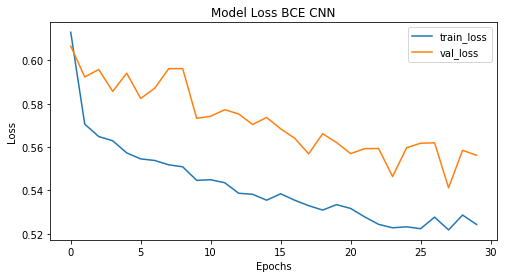

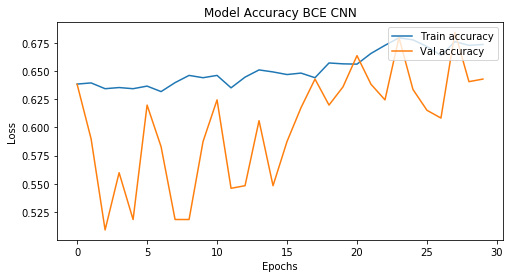

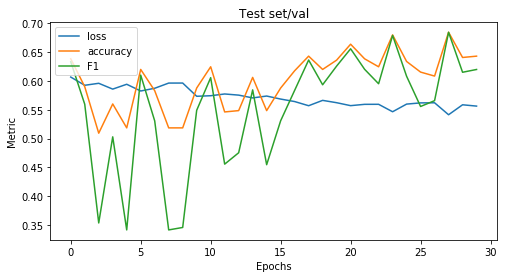

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.620204  0.690302  0.783370     0.669205       0.718395   
Confirmed       0.620204  0.690302  0.457038     0.669205       0.591017   

                Recall raw  
False Positive    0.861267  
Confirmed         0.372578

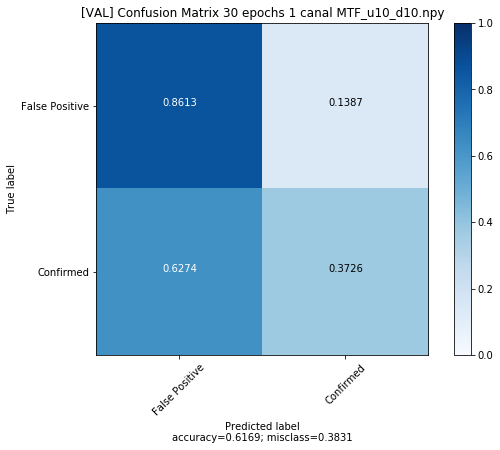

In [18]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    #x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 
    

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.681708 
 - val_f1: 0.693916 
 - val_f1: 0.677323 
 - val_f1: 0.687136 
 - val_f1: 0.702035 
 - val_f1: 0.703709 
 - val_f1: 0.710077 
 - val_f1: 0.713266 
 - val_f1: 0.694591 
 - val_f1: 0.708377 
 - val_f1: 0.709526 
 - val_f1: 0.686636 
 - val_f1: 0.712616 
 - val_f1: 0.702621 
 - val_f1: 0.719128 
 - val_f1: 0.702035 
 - val_f1: 0.712202 
 - val_f1: 0.706878 
 - val_f1: 0.712202 
 - val_f1: 0.709526 
 - val_f1: 0.702371 
 - val_f1: 0.720281 
 - val_f1: 0.711136 
 - val_f1: 0.713266 
 - val_f1: 0.716410 
 - val_f1: 0.704148 
 - val_f1: 0.705058 
 - val_f1: 0.715397 
 - val_f1: 0.703791 
 - val_f1: 0.698266 


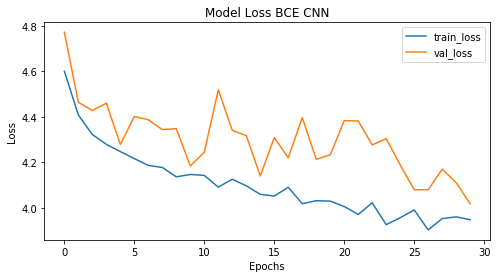

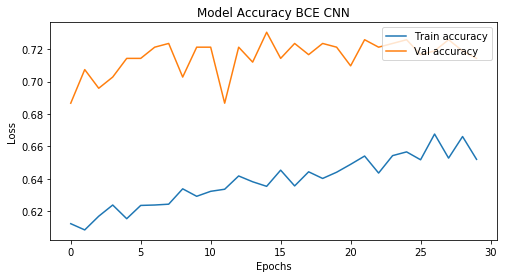

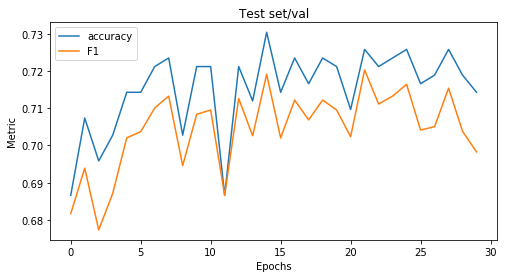

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.629146  0.630344  0.608071     0.622817       0.978648   
Confirmed       0.629146  0.630344  0.650222     0.622817       0.485988   

                Recall raw  
False Positive    0.441059  
Confirmed         0.982116

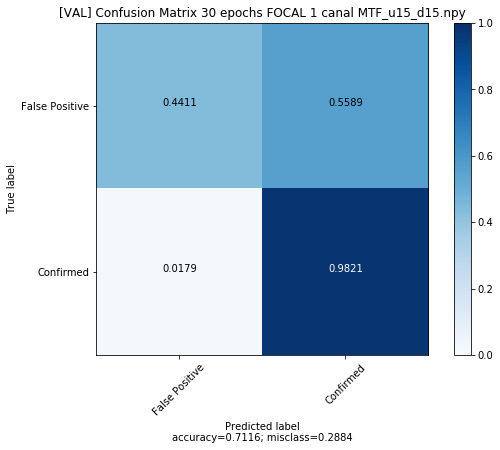

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.683480 
 - val_f1: 0.709007 
 - val_f1: 0.693400 
 - val_f1: 0.714327 
 - val_f1: 0.687372 
 - val_f1: 0.703557 
 - val_f1: 0.714327 
 - val_f1: 0.712202 
 - val_f1: 0.714327 
 - val_f1: 0.710001 
 - val_f1: 0.711136 
 - val_f1: 0.718547 
 - val_f1: 0.711078 
 - val_f1: 0.710938 
 - val_f1: 0.713266 
 - val_f1: 0.707095 
 - val_f1: 0.712202 
 - val_f1: 0.714869 
 - val_f1: 0.715223 
 - val_f1: 0.713777 
 - val_f1: 0.697963 
 - val_f1: 0.714869 
 - val_f1: 0.717529 
 - val_f1: 0.727308 
 - val_f1: 0.715397 
 - val_f1: 0.708959 
 - val_f1: 0.708959 
 - val_f1: 0.713038 
 - val_f1: 0.728554 
 - val_f1: 0.722266 


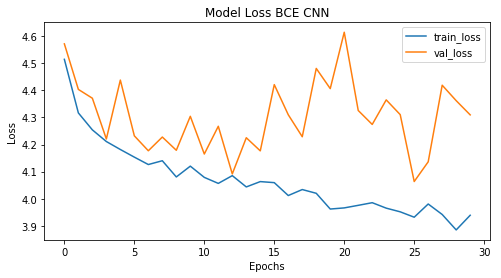

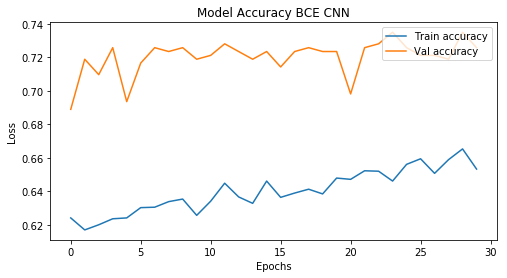

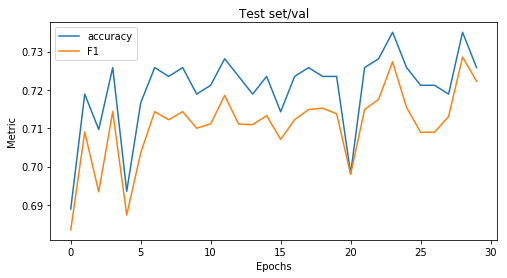

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.669556   0.67049  0.687129     0.674833       0.897801   
Confirmed       0.669556   0.67049  0.651982     0.674833       0.517031   

                Recall raw  
False Positive    0.556536  
Confirmed         0.882265

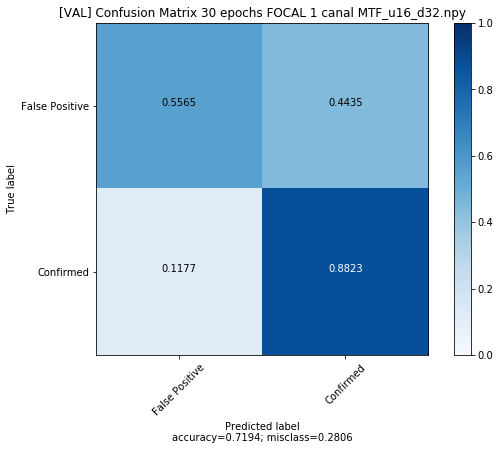

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.699987 
 - val_f1: 0.709007 
 - val_f1: 0.705285 
 - val_f1: 0.715397 
 - val_f1: 0.709007 
 - val_f1: 0.687826 
 - val_f1: 0.717529 
 - val_f1: 0.713266 
 - val_f1: 0.715397 
 - val_f1: 0.692473 
 - val_f1: 0.712741 
 - val_f1: 0.712137 
 - val_f1: 0.692647 
 - val_f1: 0.708487 
 - val_f1: 0.689180 
 - val_f1: 0.715893 
 - val_f1: 0.704724 
 - val_f1: 0.714869 
 - val_f1: 0.712741 
 - val_f1: 0.699322 
 - val_f1: 0.714869 
 - val_f1: 0.718266 
 - val_f1: 0.710077 
 - val_f1: 0.708796 
 - val_f1: 0.716410 
 - val_f1: 0.704432 
 - val_f1: 0.715911 
 - val_f1: 0.720416 
 - val_f1: 0.707379 
 - val_f1: 0.691542 


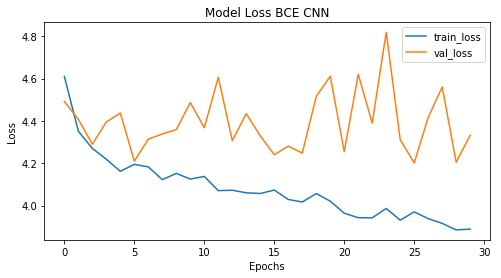

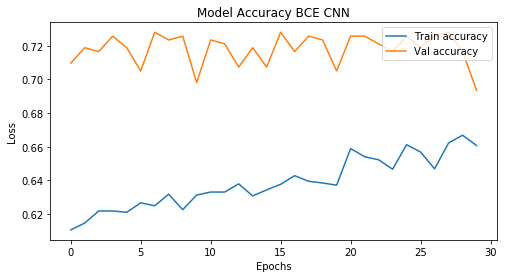

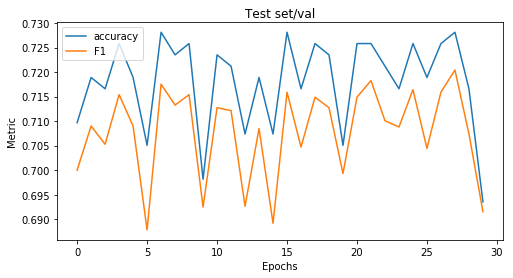

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.67486  0.678832  0.710798     0.685653       0.857305   
Confirmed        0.67486  0.678832  0.638921     0.685653       0.526570   

                Recall raw  
False Positive    0.607057  
Confirmed         0.812221

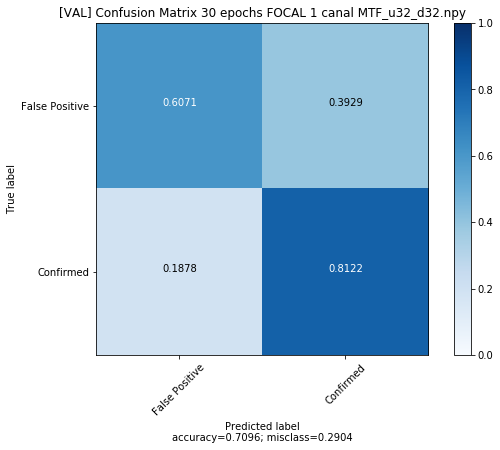

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.674636 
 - val_f1: 0.685519 
 - val_f1: 0.686117 
 - val_f1: 0.688347 
 - val_f1: 0.689925 
 - val_f1: 0.700223 
 - val_f1: 0.699326 
 - val_f1: 0.695388 
 - val_f1: 0.693916 
 - val_f1: 0.706362 
 - val_f1: 0.706200 
 - val_f1: 0.707379 
 - val_f1: 0.702327 
 - val_f1: 0.706262 
 - val_f1: 0.719035 
 - val_f1: 0.704724 
 - val_f1: 0.701447 
 - val_f1: 0.713777 
 - val_f1: 0.713081 
 - val_f1: 0.719035 
 - val_f1: 0.714869 
 - val_f1: 0.717357 
 - val_f1: 0.722446 
 - val_f1: 0.704148 
 - val_f1: 0.701447 
 - val_f1: 0.692424 
 - val_f1: 0.707405 
 - val_f1: 0.695388 
 - val_f1: 0.712202 
 - val_f1: 0.698853 


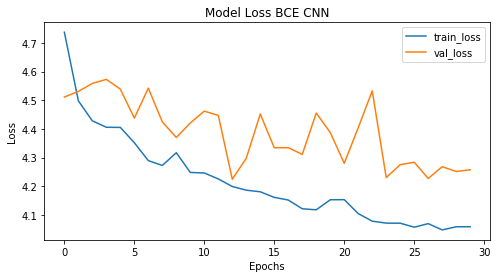

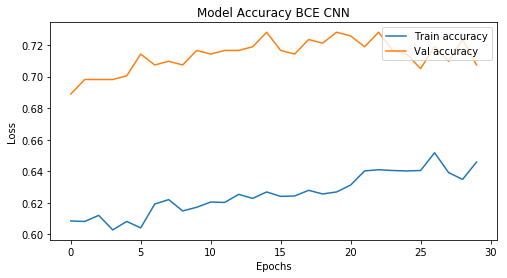

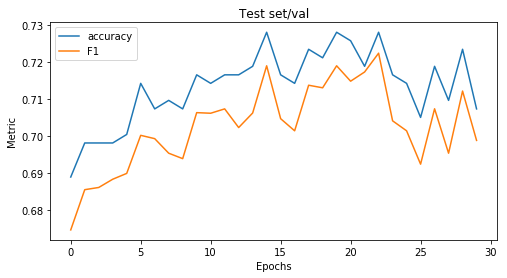

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.656719  0.656934  0.665310     0.659299       0.909597   
Confirmed       0.656719  0.656934  0.648128     0.659299       0.505421   

                Recall raw  
False Positive    0.524459  
Confirmed         0.903130

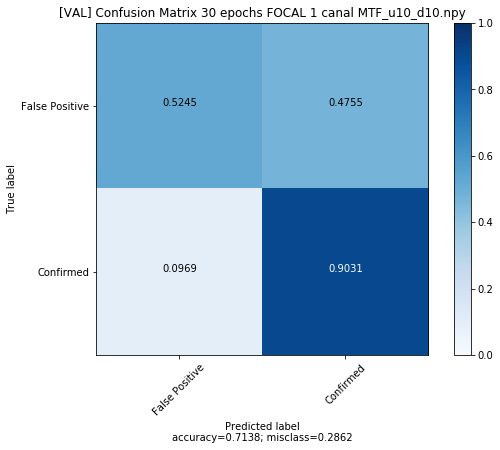

In [19]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 
    

### Invertido 

#### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.495023 
 - val_f1: 0.346707 
 - val_f1: 0.480162 
 - val_f1: 0.489679 
 - val_f1: 0.393513 
 - val_f1: 0.582956 
 - val_f1: 0.570142 
 - val_f1: 0.420308 
 - val_f1: 0.533946 
 - val_f1: 0.501975 
 - val_f1: 0.496753 
 - val_f1: 0.495838 
 - val_f1: 0.476553 
 - val_f1: 0.517871 
 - val_f1: 0.536054 
 - val_f1: 0.514652 
 - val_f1: 0.630380 
 - val_f1: 0.554931 
 - val_f1: 0.503016 
 - val_f1: 0.648941 
 - val_f1: 0.500717 
 - val_f1: 0.604905 
 - val_f1: 0.582003 
 - val_f1: 0.527198 
 - val_f1: 0.529009 
 - val_f1: 0.517217 
 - val_f1: 0.614949 
 - val_f1: 0.601908 
 - val_f1: 0.557143 
 - val_f1: 0.503622 


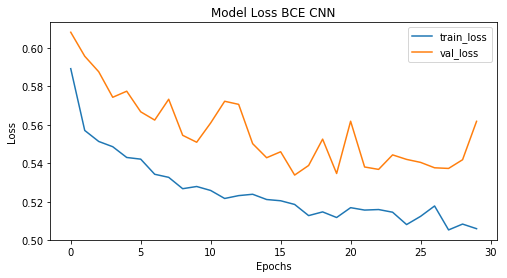

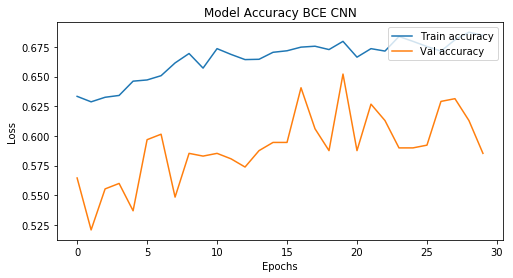

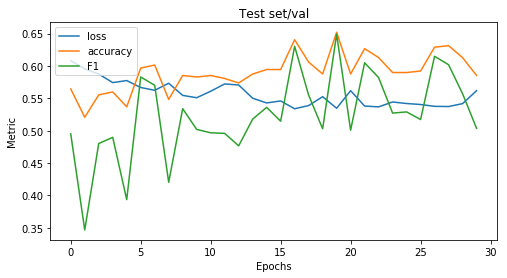

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.559037  0.694995  0.803889     0.632569       0.690668   
Confirmed       0.559037  0.694995  0.314185     0.632569       0.736264   

                Recall raw  
False Positive    0.961508  
Confirmed         0.199702

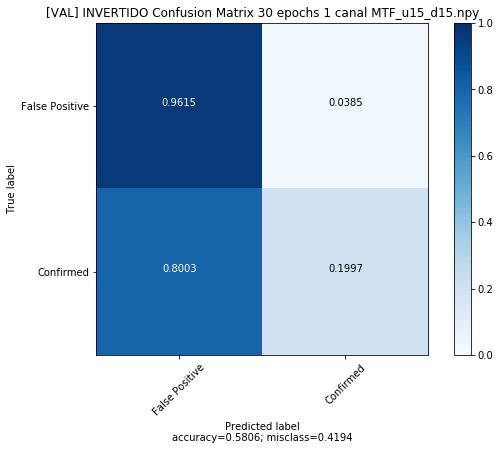

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.645131 


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.595903 
 - val_f1: 0.357139 
 - val_f1: 0.484335 
 - val_f1: 0.704020 
 - val_f1: 0.528350 
 - val_f1: 0.608356 
 - val_f1: 0.451422 
 - val_f1: 0.542720 
 - val_f1: 0.477057 
 - val_f1: 0.530782 
 - val_f1: 0.505820 
 - val_f1: 0.540922 
 - val_f1: 0.536792 
 - val_f1: 0.647343 
 - val_f1: 0.556412 
 - val_f1: 0.465235 
 - val_f1: 0.494369 
 - val_f1: 0.520155 
 - val_f1: 0.634467 
 - val_f1: 0.532158 
 - val_f1: 0.508408 
 - val_f1: 0.599859 
 - val_f1: 0.598047 
 - val_f1: 0.599959 
 - val_f1: 0.586612 
 - val_f1: 0.507974 
 - val_f1: 0.504641 
 - val_f1: 0.622047 


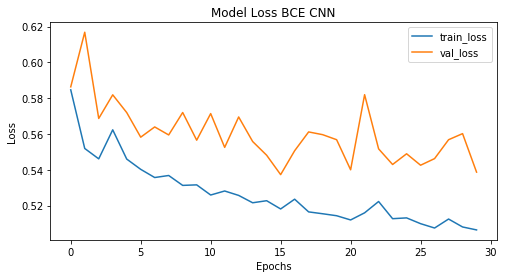

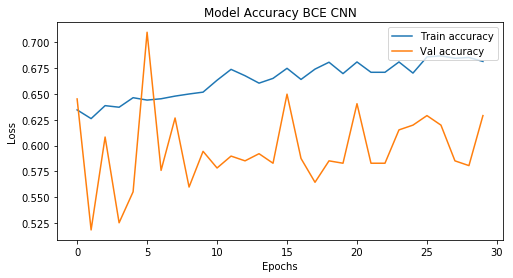

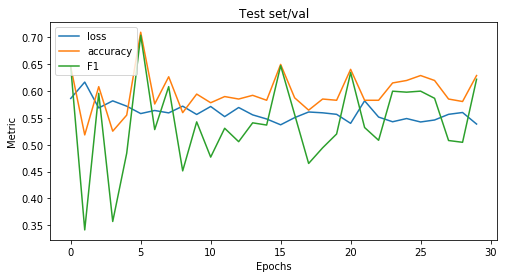

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.659446  0.697602  0.773437     0.693679       0.753998   
Confirmed       0.659446  0.697602  0.545455     0.693679       0.575207   

                Recall raw  
False Positive    0.793905  
Confirmed         0.518629

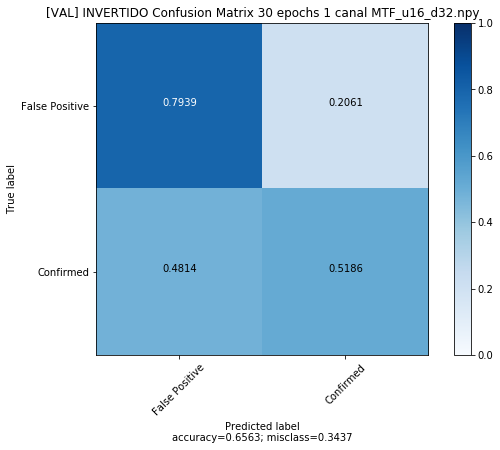

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.519875 
 - val_f1: 0.346707 
 - val_f1: 0.552110 
 - val_f1: 0.553405 
 - val_f1: 0.462600 
 - val_f1: 0.468655 
 - val_f1: 0.509351 
 - val_f1: 0.567700 
 - val_f1: 0.616758 
 - val_f1: 0.509351 
 - val_f1: 0.506328 
 - val_f1: 0.631899 
 - val_f1: 0.463710 
 - val_f1: 0.687732 
 - val_f1: 0.734599 
 - val_f1: 0.493524 
 - val_f1: 0.510466 
 - val_f1: 0.695794 
 - val_f1: 0.520971 
 - val_f1: 0.499742 
 - val_f1: 0.514179 
 - val_f1: 0.613914 
 - val_f1: 0.499197 
 - val_f1: 0.464113 
 - val_f1: 0.662879 
 - val_f1: 0.614757 
 - val_f1: 0.493754 
 - val_f1: 0.607459 
 - val_f1: 0.485570 
 - val_f1: 0.485466 


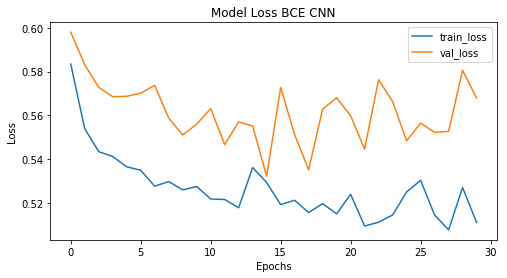

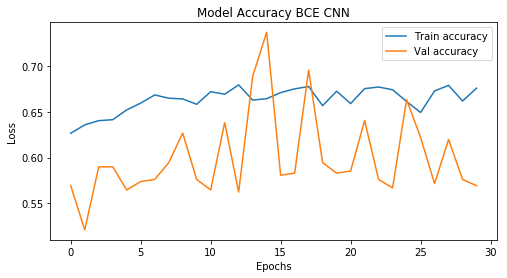

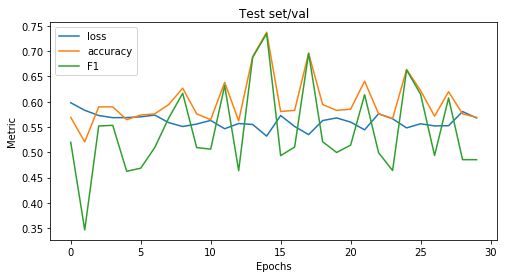

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.558722  0.697602  0.806279     0.633066       0.690899   
Confirmed       0.558722  0.697602  0.311164     0.633066       0.766082   

                Recall raw  
False Positive    0.967923  
Confirmed         0.195231

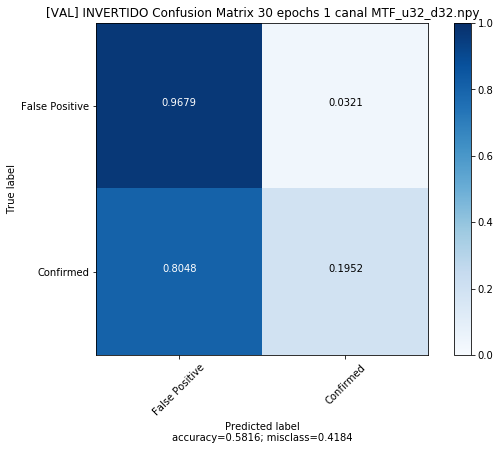

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.341426 
 - val_f1: 0.381360 
 - val_f1: 0.351944 
 - val_f1: 0.394765 
 - val_f1: 0.445420 
 - val_f1: 0.458771 
 - val_f1: 0.704441 
 - val_f1: 0.408173 
 - val_f1: 0.492519 
 - val_f1: 0.394517 
 - val_f1: 0.561915 
 - val_f1: 0.462665 
 - val_f1: 0.346707 
 - val_f1: 0.367401 
 - val_f1: 0.543730 
 - val_f1: 0.555911 
 - val_f1: 0.494239 
 - val_f1: 0.628910 
 - val_f1: 0.618369 
 - val_f1: 0.556547 
 - val_f1: 0.584743 
 - val_f1: 0.597943 
 - val_f1: 0.624401 
 - val_f1: 0.647149 
 - val_f1: 0.629948 
 - val_f1: 0.652507 
 - val_f1: 0.475000 
 - val_f1: 0.579690 
 - val_f1: 0.534222 
 - val_f1: 0.637769 


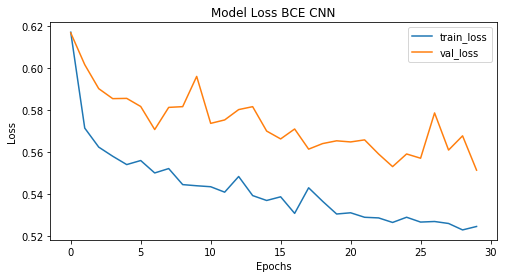

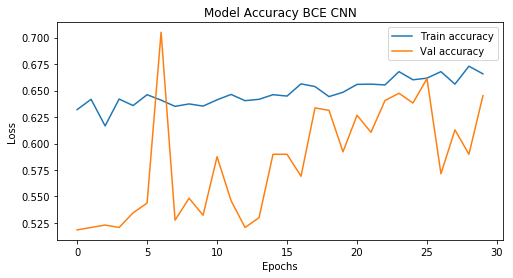

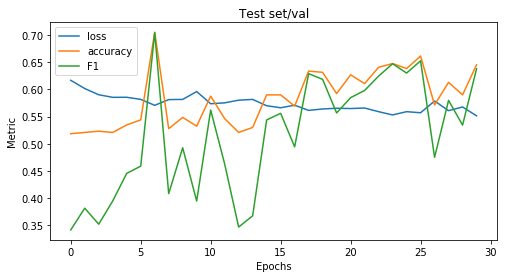

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.636325  0.667883  0.743455     0.668498       0.746764   
Confirmed       0.636325  0.667883  0.529194     0.668498       0.524927   

                Recall raw  
False Positive    0.740176  
Confirmed         0.533532

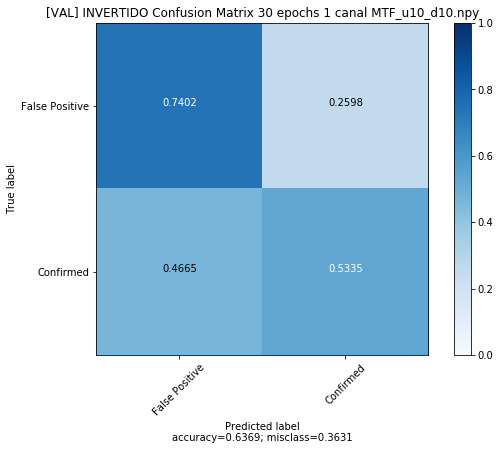

In [20]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs 1 canal '+str(data)) 
    

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.693802 
 - val_f1: 0.696238 
 - val_f1: 0.695225 
 - val_f1: 0.687806 
 - val_f1: 0.700493 
 - val_f1: 0.703709 
 - val_f1: 0.703709 
 - val_f1: 0.680874 
 - val_f1: 0.707954 
 - val_f1: 0.694591 
 - val_f1: 0.685228 
 - val_f1: 0.703709 
 - val_f1: 0.695225 
 - val_f1: 0.706362 
 - val_f1: 0.700843 
 - val_f1: 0.710614 
 - val_f1: 0.706841 
 - val_f1: 0.689926 
 - val_f1: 0.704398 
 - val_f1: 0.707405 
 - val_f1: 0.710077 
 - val_f1: 0.696631 
 - val_f1: 0.698737 
 - val_f1: 0.712741 
 - val_f1: 0.714327 
 - val_f1: 0.707405 
 - val_f1: 0.711647 
 - val_f1: 0.704724 
 - val_f1: 0.712202 
 - val_f1: 0.715397 


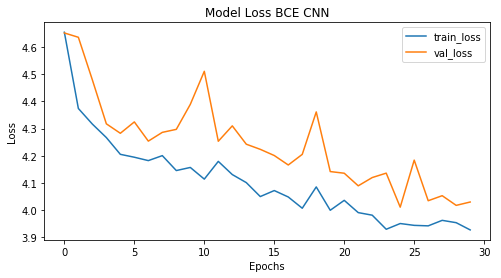

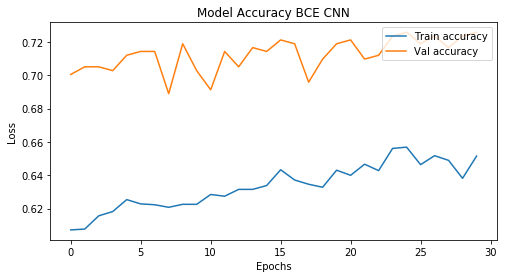

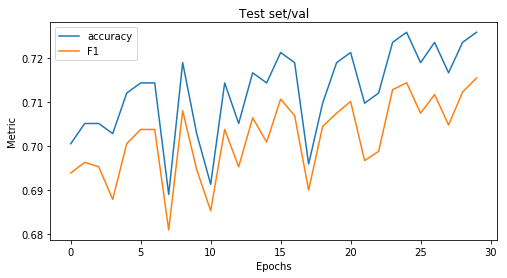

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.655888  0.655892  0.656965     0.656211       0.933530   
Confirmed       0.655888  0.655892  0.654812     0.656211       0.504432   

                Recall raw  
False Positive    0.506816  
Confirmed         0.932936

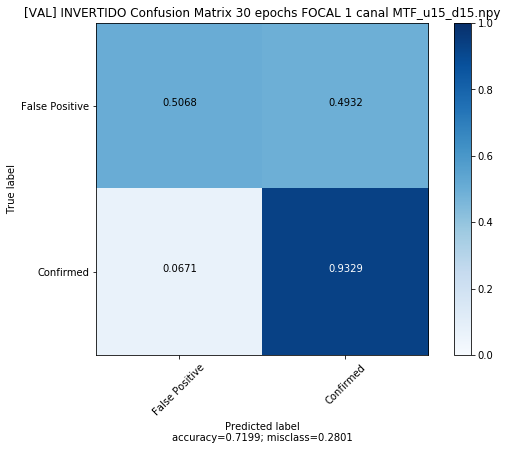

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.700493 
 - val_f1: 0.694527 
 - val_f1: 0.698737 
 - val_f1: 0.691311 
 - val_f1: 0.701447 
 - val_f1: 0.683480 
 - val_f1: 0.691311 
 - val_f1: 0.691987 
 - val_f1: 0.695388 
 - val_f1: 0.729206 
 - val_f1: 0.708959 
 - val_f1: 0.712616 
 - val_f1: 0.705373 
 - val_f1: 0.700843 
 - val_f1: 0.712202 
 - val_f1: 0.704749 
 - val_f1: 0.682212 
 - val_f1: 0.693916 
 - val_f1: 0.708487 
 - val_f1: 0.696018 
 - val_f1: 0.717823 
 - val_f1: 0.701417 
 - val_f1: 0.709671 
 - val_f1: 0.710077 
 - val_f1: 0.698120 
 - val_f1: 0.729893 
 - val_f1: 0.705831 
 - val_f1: 0.703166 
 - val_f1: 0.707379 
 - val_f1: 0.685856 


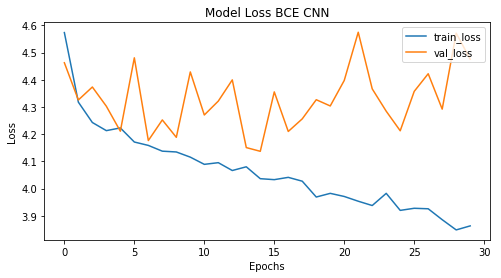

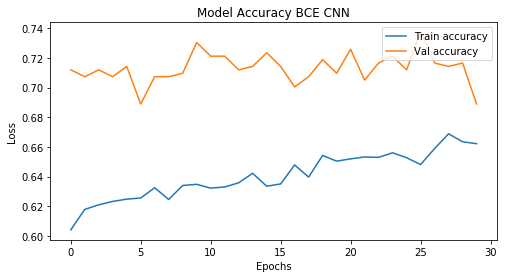

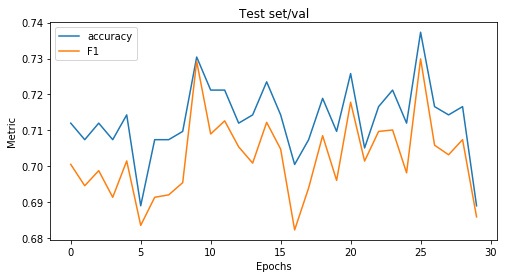

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.681193  0.686653  0.722914     0.693722       0.850325   
Confirmed       0.681193  0.686653  0.639472     0.693722       0.535141   

                Recall raw  
False Positive    0.628709  
Confirmed         0.794337

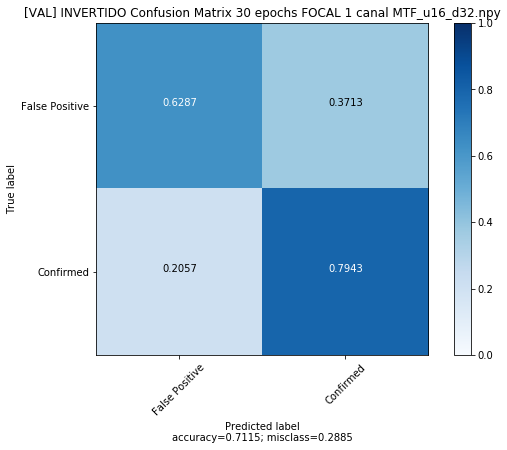

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.706878 
 - val_f1: 0.702621 
 - val_f1: 0.703224 
 - val_f1: 0.704148 
 - val_f1: 0.704148 
 - val_f1: 0.702621 
 - val_f1: 0.703596 
 - val_f1: 0.700843 
 - val_f1: 0.697487 
 - val_f1: 0.717356 
 - val_f1: 0.713266 
 - val_f1: 0.703166 
 - val_f1: 0.715911 
 - val_f1: 0.698087 
 - val_f1: 0.713777 
 - val_f1: 0.707954 
 - val_f1: 0.707954 
 - val_f1: 0.710077 
 - val_f1: 0.665385 
 - val_f1: 0.713266 
 - val_f1: 0.701587 
 - val_f1: 0.705285 
 - val_f1: 0.707379 
 - val_f1: 0.710614 
 - val_f1: 0.705831 
 - val_f1: 0.703709 
 - val_f1: 0.705831 
 - val_f1: 0.697058 
 - val_f1: 0.711644 
 - val_f1: 0.708487 


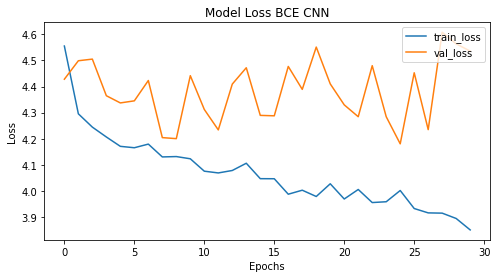

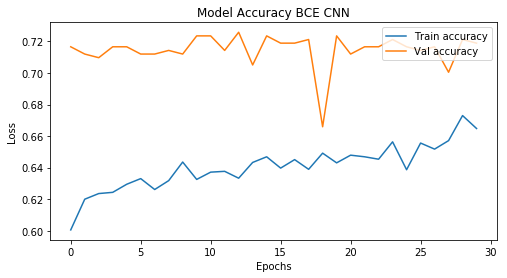

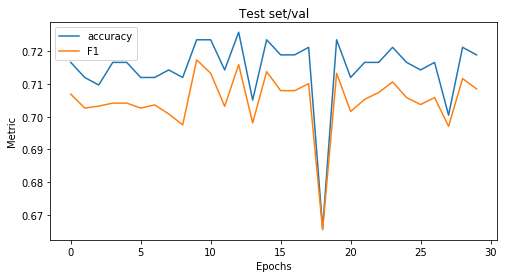

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.665276  0.665276  0.665276     0.665276       0.950820   
Confirmed       0.665276  0.665276  0.665276     0.665276       0.511628   

                Recall raw  
False Positive    0.511628  
Confirmed         0.950820

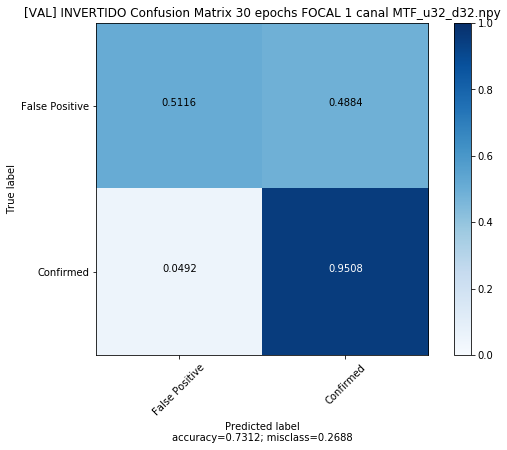

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.675917 
 - val_f1: 0.683474 
 - val_f1: 0.678749 
 - val_f1: 0.694111 
 - val_f1: 0.705285 
 - val_f1: 0.698737 
 - val_f1: 0.702621 
 - val_f1: 0.654404 
 - val_f1: 0.692922 
 - val_f1: 0.696631 
 - val_f1: 0.702608 
 - val_f1: 0.703166 
 - val_f1: 0.696631 
 - val_f1: 0.684367 
 - val_f1: 0.699338 
 - val_f1: 0.691492 
 - val_f1: 0.691987 
 - val_f1: 0.687136 
 - val_f1: 0.699466 
 - val_f1: 0.706878 
 - val_f1: 0.697229 
 - val_f1: 0.694742 
 - val_f1: 0.689096 
 - val_f1: 0.700843 
 - val_f1: 0.691311 
 - val_f1: 0.707934 
 - val_f1: 0.707379 
 - val_f1: 0.686450 
 - val_f1: 0.715397 
 - val_f1: 0.685746 


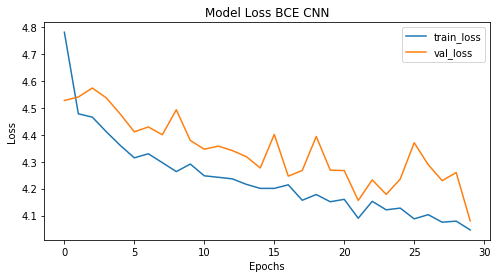

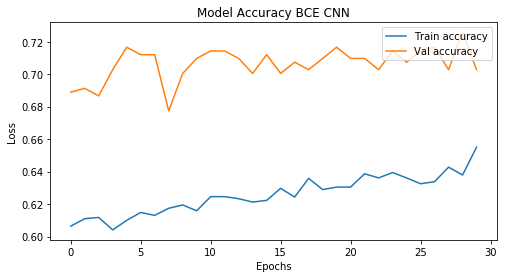

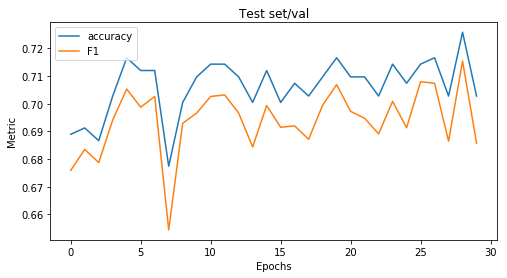

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.618295  0.619917  0.593419     0.610825       0.974359   
Confirmed       0.618295  0.619917  0.643172     0.610825       0.478863   

                Recall raw  
False Positive    0.426624  
Confirmed         0.979136

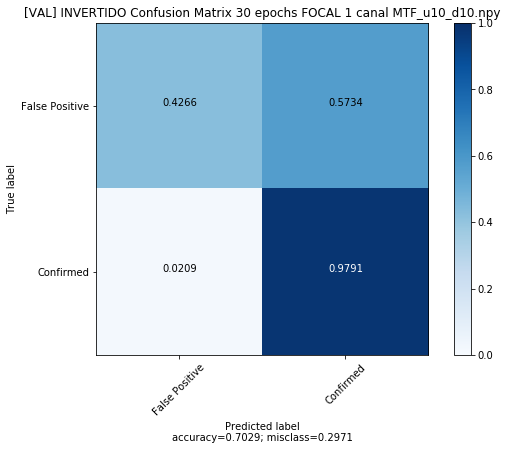

In [21]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 
    

## Modelo 3

### No invertido 

#### BCE

Entrenando usando representación 	Up: 15   Down: 15


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.350897 
 - val_f1: 0.351944 
 - val_f1: 0.414921 
 - val_f1: 0.628511 
 - val_f1: 0.356069 
 - val_f1: 0.425243 
 - val_f1: 0.420772 
 - val_f1: 0.539124 
 - val_f1: 0.692960 
 - val_f1: 0.498106 
 - val_f1: 0.410326 
 - val_f1: 0.625044 
 - val_f1: 0.679108 
 - val_f1: 0.356069 
 - val_f1: 0.599331 
 - val_f1: 0.673226 
 - val_f1: 0.575010 
 - val_f1: 0.553345 
 - val_f1: 0.633036 
 - val_f1: 0.610952 
 - val_f1: 0.685969 
 - val_f1: 0.514652 
 - val_f1: 0.516841 
 - val_f1: 0.572959 
 - val_f1: 0.718434 


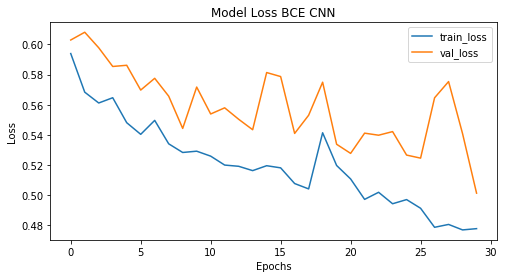

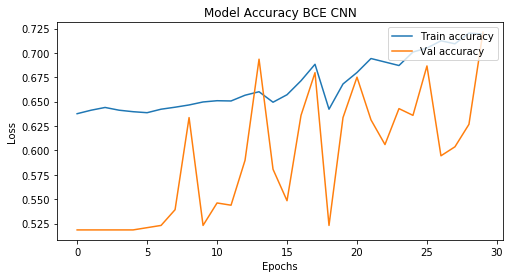

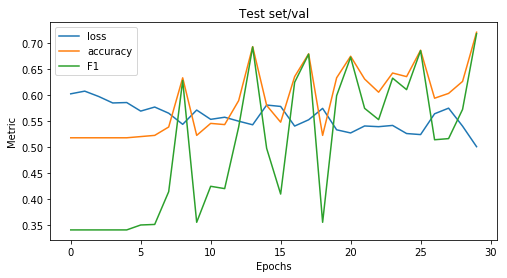

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.693183  0.696038  0.722777     0.702071       0.887850   
Confirmed       0.693183  0.696038  0.663589     0.702071       0.541431   

                Recall raw  
False Positive    0.609463  
Confirmed         0.856930

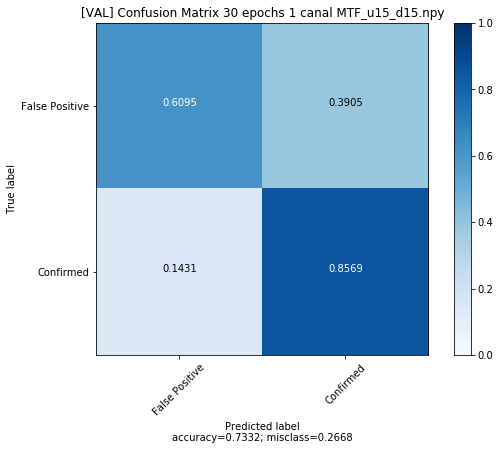

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.365635 
 - val_f1: 0.351944 
 - val_f1: 0.370200 
 - val_f1: 0.365173 
 - val_f1: 0.585274 
 - val_f1: 0.388698 
 - val_f1: 0.444258 
 - val_f1: 0.411102 
 - val_f1: 0.512459 
 - val_f1: 0.591858 
 - val_f1: 0.585050 
 - val_f1: 0.473448 
 - val_f1: 0.562415 
 - val_f1: 0.684048 
 - val_f1: 0.558569 
 - val_f1: 0.651708 
 - val_f1: 0.648624 
 - val_f1: 0.616976 
 - val_f1: 0.524704 
 - val_f1: 0.612899 
 - val_f1: 0.626424 
 - val_f1: 0.650534 
 - val_f1: 0.621241 
 - val_f1: 0.528127 
 - val_f1: 0.500717 
 - val_f1: 0.640252 


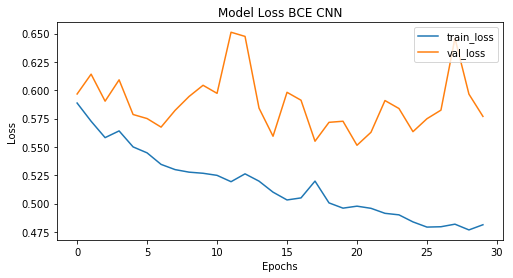

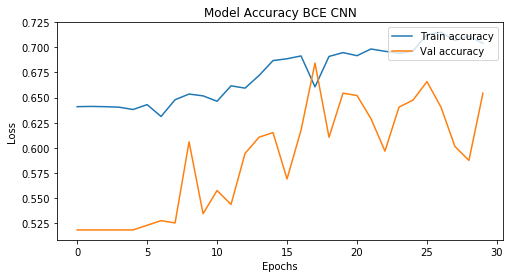

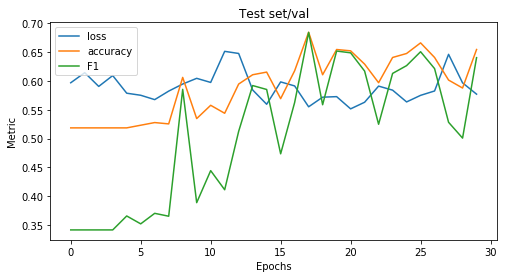

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.683406   0.72367  0.796311     0.717313       0.764576   
Confirmed       0.683406   0.72367  0.570502     0.717313       0.625222   

                Recall raw  
False Positive    0.830794  
Confirmed         0.524590

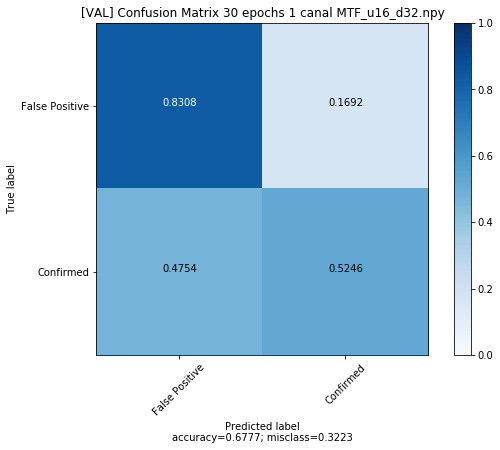

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.389794 
 - val_f1: 0.369061 
 - val_f1: 0.696722 
 - val_f1: 0.361199 
 - val_f1: 0.524466 
 - val_f1: 0.420308 
 - val_f1: 0.423863 
 - val_f1: 0.704236 
 - val_f1: 0.602332 
 - val_f1: 0.672811 
 - val_f1: 0.502976 
 - val_f1: 0.552836 
 - val_f1: 0.626742 
 - val_f1: 0.627716 
 - val_f1: 0.536054 
 - val_f1: 0.469814 
 - val_f1: 0.650789 
 - val_f1: 0.592989 
 - val_f1: 0.524975 
 - val_f1: 0.603808 
 - val_f1: 0.506307 
 - val_f1: 0.527198 
 - val_f1: 0.575374 
 - val_f1: 0.598047 
 - val_f1: 0.567455 


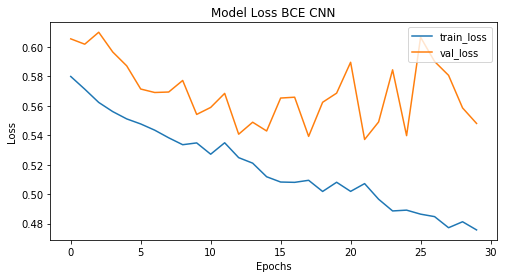

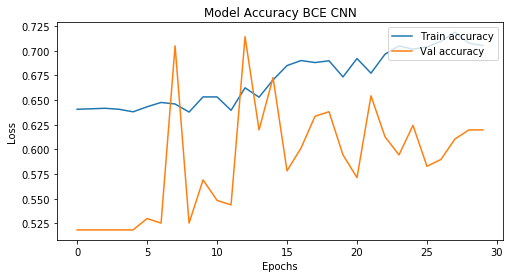

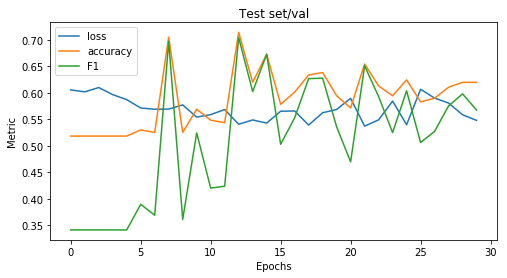

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.619743  0.714807  0.809871     0.676841       0.714724   
Confirmed       0.619743  0.714807  0.429614     0.676841       0.715278   

                Recall raw  
False Positive    0.934242  
Confirmed         0.307004

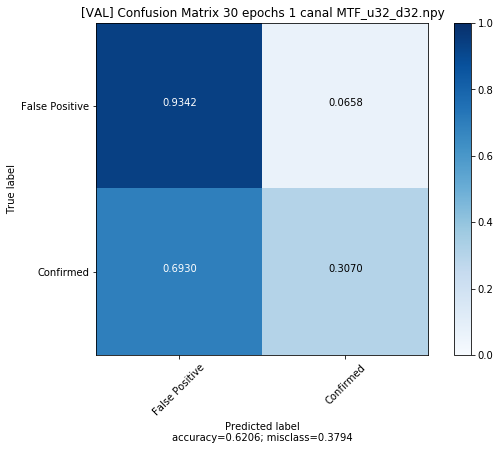

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.382646 
 - val_f1: 0.351944 
 - val_f1: 0.346707 
 - val_f1: 0.649796 
 - val_f1: 0.398292 
 - val_f1: 0.716410 
 - val_f1: 0.634032 
 - val_f1: 0.503226 
 - val_f1: 0.520599 
 - val_f1: 0.562212 
 - val_f1: 0.583375 
 - val_f1: 0.454364 
 - val_f1: 0.386242 
 - val_f1: 0.475929 
 - val_f1: 0.584191 
 - val_f1: 0.692528 
 - val_f1: 0.593082 
 - val_f1: 0.584873 
 - val_f1: 0.715579 
 - val_f1: 0.606655 
 - val_f1: 0.614660 
 - val_f1: 0.605249 
 - val_f1: 0.555591 
 - val_f1: 0.555469 
 - val_f1: 0.602676 


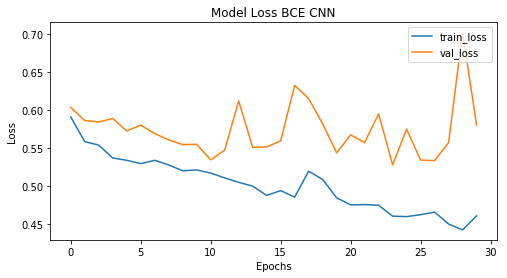

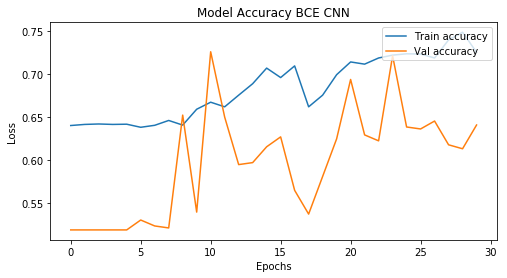

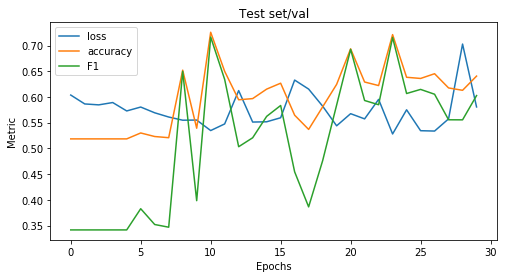

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.667042  0.740355  0.823279     0.713962       0.738383   
Confirmed       0.667042  0.740355  0.510806     0.713962       0.749280   

                Recall raw  
False Positive    0.930233  
Confirmed         0.387481

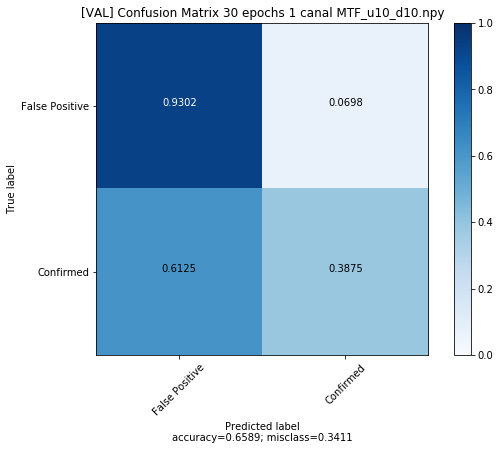

In [22]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))    
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal Loss

In [23]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 

Entrenando usando representación 	Up: 15   Down: 15


ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_78/convolution' (op: 'Conv2D') with input shapes: [?,2,2,128], [3,3,128,128].

### INVERTIDO

#### BCE

In [ ]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1) 
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal loss

In [ ]:
for data in os.listdir('../../../Data_PIIC/Datapi/inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_1= np.expand_dims(np.asarray(channel_1), axis=-1)
    
    x_train = channel_1[mask_train]
    x_val = channel_1[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,1), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] INVERTIDO Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 